In [300]:
import os
from tqdm import tqdm
from pprint import pprint

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import warnings
warnings.filterwarnings('ignore')

In [2]:
PATH_TO_DATA = "CK+_lands/CK+_centered"
PATH_TO_LABEL = "CK+_lands/CK+/emotion.csv"

In [3]:
os.chdir("..")

In [4]:
def load_last_faces(data, labels, only_labelled=True):
    def fuse_df(base_df, visage_dir, tmp_id, data, target=-1):
        coords = {str(i):x for i, x in enumerate(data.to_numpy())}
        new_line = {
            "subject": visage_dir,
            "file": tmp_id,
        }
        new_line = new_line | coords
        new_line = pd.DataFrame(new_line, index=[0])

        # new_line["coords"] = new_line.iloc[:, 2:].to_numpy().tolist()

        # new_line = new_line.drop([str(i) for i in range(136)], axis=1)
        return pd.concat([base_df, new_line])

    last_faces = pd.DataFrame()
    labels = pd.read_csv(labels, delimiter=";")

    for visage_dir in os.listdir(data):
        visage_data = pd.read_csv(os.path.join(data, visage_dir, "omlands.csv"), delimiter=";", header=None)
        tmp_id = visage_data.iloc[0, 0]
        for row_id in visage_data.index:
            if visage_data.iloc[row_id, 0] != tmp_id:
                last_faces = fuse_df(last_faces, visage_dir, tmp_id, visage_data.iloc[row_id-1, 1:])
                tmp_id = visage_data.iloc[row_id, 0]
        last_faces = fuse_df(last_faces, visage_dir, tmp_id, visage_data.iloc[row_id-1, 1:])


    last_faces = pd.merge(last_faces, labels, on=["subject", "file"], how="inner" if only_labelled else "outer")
    
    return last_faces

In [5]:
def create_data(data:pd.DataFrame, final_number:int, random_range=2):
    new_faces_nb = final_number // len(data["emotion"].value_counts()) + 1
    new_data = []
    new_faces_count = {}
    while len(data)+len(new_data) < final_number:
        for emotion in data["emotion"].unique():
            if emotion not in new_faces_count:
                new_faces_count[emotion] = 0

            if len(data.where(data["emotion"] == emotion).dropna()) + new_faces_count[emotion] < new_faces_nb:
                new_faces_count[emotion] += 1
                new_line = data.where(data["emotion"] == emotion).dropna().sample()
                for i in range(136):
                    new_line[str(i)] = new_line[str(i)] + np.random.uniform(-random_range, random_range)
                new_data.append(new_line.to_numpy().tolist()[0])
    return pd.concat([data, pd.DataFrame(new_data, columns=data.columns)], ignore_index=True)

In [7]:
facial_points = load_last_faces(PATH_TO_DATA, PATH_TO_LABEL)

In [183]:
facial_points

,subject,file,0,1,2,3,4,5,6,7,...,127,128,129,130,131,132,133,134,135,emotion
0,S095,1,-239.50,409.0,-232.50,475.0,-220.50,539.0,-205.50,603.0,...,575.0,61.50,619.0,24.50,649.0,2.50,652.0,-19.50,649.0,3
1,S095,2,-241.25,412.0,-235.25,470.0,-227.25,527.0,-215.25,586.0,...,564.0,72.75,588.0,23.75,600.0,-2.25,602.0,-27.25,599.0,2
2,S095,6,-242.00,406.0,-236.00,464.0,-228.00,520.0,-218.00,577.0,...,560.0,64.00,573.0,22.00,565.0,0.00,566.0,-23.00,563.0,5
3,S095,7,-246.25,397.0,-242.25,453.0,-235.25,509.0,-226.25,569.0,...,558.0,81.75,571.0,22.75,596.0,-5.25,598.0,-34.25,593.0,1
4,S037,1,-207.75,455.0,-203.75,514.0,-194.75,575.0,-178.75,633.0,...,634.0,53.25,673.0,16.25,718.0,-6.75,722.0,-28.75,717.0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
352,S102,6,-202.25,320.0,-195.25,378.0,-184.25,433.0,-173.25,489.0,...,531.0,60.75,539.0,21.75,533.0,3.75,534.0,-11.25,533.0,6
353,S102,8,-205.75,326.0,-198.75,386.0,-187.75,446.0,-175.75,503.0,...,505.0,65.25,540.0,24.25,562.0,4.25,564.0,-13.75,561.0,3
354,S102,9,-206.25,320.0,-199.25,376.0,-189.25,430.0,-178.25,483.0,...,478.0,69.75,481.0,26.75,478.0,6.75,480.0,-13.25,479.0,5
355,S120,1,-218.25,407.0,-211.25,473.0,-201.25,537.0,-190.25,597.0,...,608.0,69.75,630.0,23.75,605.0,0.75,606.0,-20.25,604.0,6


In [166]:
X_train, X_test, y_train, y_test = train_test_split(facial_points.loc[:, "0":"135"], facial_points["emotion"], test_size=0.333)

# Unoptimised models

## Decision Tree

In [19]:
cross_val_score(DecisionTreeClassifier(), X_train, y_train, cv=5).mean()

0.56554856743536

In [26]:
tree = DecisionTreeClassifier().fit(X_train, y_train)
tree.score(X_test, y_test)

0.5126050420168067

## Random Forest

In [20]:
cross_val_score(RandomForestClassifier(), X_train, y_train, cv=5).mean()

0.6105520614954577

In [27]:
rd_forest = RandomForestClassifier().fit(X_train, y_train)
rd_forest.score(X_test, y_test)

0.6050420168067226

## MLP Classifier

In [21]:
cross_val_score(MLPClassifier(), X_train, y_train, cv=5).mean()

0.3603074772886094

In [28]:
mlp = MLPClassifier().fit(X_train, y_train)
mlp.score(X_test, y_test)

0.31932773109243695

## Logistic Regression

In [22]:
cross_val_score(LogisticRegression(), X_train, y_train, cv=5).mean()

0.8240391334730959

In [29]:
lr = LogisticRegression().fit(X_train, y_train)
lr.score(X_test, y_test)

0.8151260504201681

## SVC

In [34]:
cross_val_score(SVC(), X_train, y_train, cv=5).mean()

0.36968085106382975

In [35]:
svc = SVC().fit(X_train, y_train)
svc.score(X_test, y_test)

0.3697478991596639

# Grid Searched Model

## Decision Tree

In [167]:
tree = DecisionTreeClassifier(criterion='log_loss', max_depth=13, max_leaf_nodes=100,
                                min_samples_leaf=5, min_samples_split=6)

In [168]:
cross_val_score(tree, X_train, y_train, cv=5).mean()

0.4242907801418439

In [169]:
tree.fit(X_train, y_train)
tree.score(X_test, y_test)

0.5294117647058824

## Random Forest

In [90]:
params = {
    "n_estimators": [100, 200, 300],
    "criterion": ["gini", "entropy", "log_loss"],
    "max_depth": [x for x in range(3, 15, 3)],
    "max_features": ["sqrt", "log2", None]
}

In [91]:
grid_search_rd_forest = GridSearchCV(RandomForestClassifier(), param_grid=params)
grid_search_rd_forest.fit(X_train, y_train)

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_depth': [3, 6, 9, 12],
                         'max_features': ['sqrt', 'log2', None],
                         'n_estimators': [100, 200, 300]})

In [94]:
grid_search_rd_forest.best_estimator_

RandomForestClassifier(criterion='log_loss', max_depth=9, max_features=None)

In [170]:
rd_forest = RandomForestClassifier(criterion="log_loss", max_depth=9, max_features=None)

In [171]:
cross_val_score(rd_forest, X_train, y_train, cv=5).mean()

0.5882978723404255

In [172]:
rd_forest.fit(X_train, y_train)
rd_forest.score(X_test, y_test)

0.6470588235294118

## MLP

In [148]:
params_mlp = {
    "hidden_layer_sizes": [100, 500, 1000],
    "activation": ["identity", "logistic", "tanh", "relu"],
    "solver": ["lbfgs", "sgd", "adam"],
    "max_iter": [200, 500, 1000]
}

In [151]:
grid_search_mlp = GridSearchCV(MLPClassifier(), param_grid=params_mlp, verbose=10, n_jobs=-1)
grid_search_mlp.fit(X_train, y_train)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/usr/lib/python3/dist-packages/scipy

[CV 1/5; 1/108] START activation=identity, hidden_layer_sizes=100, max_iter=200, solver=lbfgs[CV 3/5; 1/108] START activation=identity, hidden_layer_sizes=100, max_iter=200, solver=lbfgs
[CV 4/5; 1/108] START activation=identity, hidden_layer_sizes=100, max_iter=200, solver=lbfgs
[CV 2/5; 1/108] START activation=identity, hidden_layer_sizes=100, max_iter=200, solver=lbfgs
[CV 5/5; 1/108] START activation=identity, hidden_layer_sizes=100, max_iter=200, solver=lbfgs

[CV 3/5; 2/108] START activation=identity, hidden_layer_sizes=100, max_iter=200, solver=sgd
[CV 2/5; 2/108] START activation=identity, hidden_layer_sizes=100, max_iter=200, solver=sgd
[CV 1/5; 2/108] START activation=identity, hidden_layer_sizes=100, max_iter=200, solver=sgd
[CV 3/5; 2/108] END activation=identity, hidden_layer_sizes=100, max_iter=200, solver=sgd;, score=0.292 total time=   0.0s
[CV 1/5; 2/108] END activation=identity, hidden_layer_sizes=100, max_iter=200, solver=sgd;, score=0.292 total time=   0.0s
[CV 2/5;

/home/franzele/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/franzele/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/franzele/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_

[CV 4/5; 1/108] END activation=identity, hidden_layer_sizes=100, max_iter=200, solver=lbfgs;, score=0.298 total time=   0.2s
[CV 5/5; 2/108] END activation=identity, hidden_layer_sizes=100, max_iter=200, solver=sgd;, score=0.106 total time=   0.1s
[CV 3/5; 3/108] START activation=identity, hidden_layer_sizes=100, max_iter=200, solver=adam
[CV 4/5; 3/108] START activation=identity, hidden_layer_sizes=100, max_iter=200, solver=adam
[CV 5/5; 3/108] START activation=identity, hidden_layer_sizes=100, max_iter=200, solver=adam
[CV 2/5; 3/108] END activation=identity, hidden_layer_sizes=100, max_iter=200, solver=adam;, score=0.250 total time=   0.1s
[CV 4/5; 3/108] END activation=identity, hidden_layer_sizes=100, max_iter=200, solver=adam;, score=0.085 total time=   0.0s[CV 1/5; 4/108] START activation=identity, hidden_layer_sizes=100, max_iter=500, solver=lbfgs

[CV 2/5; 4/108] START activation=identity, hidden_layer_sizes=100, max_iter=500, solver=lbfgs
[CV 3/5; 4/108] START activation=iden

/home/franzele/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/franzele/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/franzele/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_

[CV 3/5; 1/108] END activation=identity, hidden_layer_sizes=100, max_iter=200, solver=lbfgs;, score=0.292 total time=   0.4s
[CV 5/5; 3/108] END activation=identity, hidden_layer_sizes=100, max_iter=200, solver=adam;, score=0.340 total time=   0.1s
[CV 4/5; 4/108] START activation=identity, hidden_layer_sizes=100, max_iter=500, solver=lbfgs
[CV 3/5; 3/108] END activation=identity, hidden_layer_sizes=100, max_iter=200, solver=adam;, score=0.375 total time=   0.2s
[CV 5/5; 4/108] START activation=identity, hidden_layer_sizes=100, max_iter=500, solver=lbfgs
[CV 3/5; 4/108] END activation=identity, hidden_layer_sizes=100, max_iter=500, solver=lbfgs;, score=0.292 total time=   0.1s[CV 2/5; 4/108] END activation=identity, hidden_layer_sizes=100, max_iter=500, solver=lbfgs;, score=0.188 total time=   0.2s
[CV 1/5; 1/108] END activation=identity, hidden_layer_sizes=100, max_iter=200, solver=lbfgs;, score=0.292 total time=   0.5s
[CV 1/5; 5/108] START activation=identity, hidden_layer_sizes=100

/home/franzele/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/franzele/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/franzele/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_

[CV 4/5; 5/108] END activation=identity, hidden_layer_sizes=100, max_iter=500, solver=sgd;, score=0.128 total time=   0.1s
[CV 4/5; 4/108] END activation=identity, hidden_layer_sizes=100, max_iter=500, solver=lbfgs;, score=0.234 total time=   0.2s
[CV 2/5; 6/108] END activation=identity, hidden_layer_sizes=100, max_iter=500, solver=adam;, score=0.312 total time=   0.1s
[CV 3/5; 7/108] START activation=identity, hidden_layer_sizes=100, max_iter=1000, solver=lbfgs
[CV 2/5; 7/108] START activation=identity, hidden_layer_sizes=100, max_iter=1000, solver=lbfgs
[CV 4/5; 7/108] START activation=identity, hidden_layer_sizes=100, max_iter=1000, solver=lbfgs
[CV 4/5; 6/108] END activation=identity, hidden_layer_sizes=100, max_iter=500, solver=adam;, score=0.234 total time=   0.1s
[CV 5/5; 7/108] START activation=identity, hidden_layer_sizes=100, max_iter=1000, solver=lbfgs
[CV 1/5; 4/108] END activation=identity, hidden_layer_sizes=100, max_iter=500, solver=lbfgs;, score=0.292 total time=   0.4s

/home/franzele/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/franzele/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)



[CV 1/5; 11/108] END activation=identity, hidden_layer_sizes=500, max_iter=200, solver=sgd;, score=0.104 total time=   0.2s
[CV 3/5; 11/108] START activation=identity, hidden_layer_sizes=500, max_iter=200, solver=sgd
[CV 2/5; 11/108] END activation=identity, hidden_layer_sizes=500, max_iter=200, solver=sgd;, score=0.167 total time=   0.1s
[CV 4/5; 11/108] START activation=identity, hidden_layer_sizes=500, max_iter=200, solver=sgd
[CV 3/5; 9/108] END activation=identity, hidden_layer_sizes=100, max_iter=1000, solver=adam;, score=0.521 total time=   0.6s
[CV 5/5; 11/108] START activation=identity, hidden_layer_sizes=500, max_iter=200, solver=sgd
[CV 3/5; 11/108] END activation=identity, hidden_layer_sizes=500, max_iter=200, solver=sgd;, score=0.292 total time=   0.2s
[CV 1/5; 12/108] START activation=identity, hidden_layer_sizes=500, max_iter=200, solver=adam
[CV 4/5; 11/108] END activation=identity, hidden_layer_sizes=500, max_iter=200, solver=sgd;, score=0.128 total time=   0.3s
[CV 2

/home/franzele/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/franzele/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/5; 12/108] END activation=identity, hidden_layer_sizes=500, max_iter=200, solver=adam;, score=0.292 total time=   0.2s
[CV 1/5; 13/108] START activation=identity, hidden_layer_sizes=500, max_iter=500, solver=lbfgs
[CV 3/5; 12/108] END activation=identity, hidden_layer_sizes=500, max_iter=200, solver=adam;, score=0.104 total time=   0.2s
[CV 2/5; 13/108] START activation=identity, hidden_layer_sizes=500, max_iter=500, solver=lbfgs
[CV 4/5; 12/108] END activation=identity, hidden_layer_sizes=500, max_iter=200, solver=adam;, score=0.128 total time=   0.2s
[CV 3/5; 13/108] START activation=identity, hidden_layer_sizes=500, max_iter=500, solver=lbfgs
[CV 5/5; 12/108] END activation=identity, hidden_layer_sizes=500, max_iter=200, solver=adam;, score=0.298 total time=   0.3s
[CV 1/5; 12/108] END activation=identity, hidden_layer_sizes=500, max_iter=200, solver=adam;, score=0.208 total time=   0.6s
[CV 4/5; 13/108] START activation=identity, hidden_layer_sizes=500, max_iter=500, solver=l

/home/franzele/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/franzele/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/franzele/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_

[CV 3/5; 13/108] END activation=identity, hidden_layer_sizes=500, max_iter=500, solver=lbfgs;, score=0.292 total time=   0.6s
[CV 1/5; 14/108] START activation=identity, hidden_layer_sizes=500, max_iter=500, solver=sgd
[CV 1/5; 14/108] END activation=identity, hidden_layer_sizes=500, max_iter=500, solver=sgd;, score=0.292 total time=   0.1s
[CV 2/5; 14/108] START activation=identity, hidden_layer_sizes=500, max_iter=500, solver=sgd
[CV 1/5; 10/108] END activation=identity, hidden_layer_sizes=500, max_iter=200, solver=lbfgs;, score=0.333 total time=   1.8s
[CV 3/5; 14/108] START activation=identity, hidden_layer_sizes=500, max_iter=500, solver=sgd
[CV 5/5; 10/108] END activation=identity, hidden_layer_sizes=500, max_iter=200, solver=lbfgs;, score=0.277 total time=   1.6s[CV 2/5; 14/108] END activation=identity, hidden_layer_sizes=500, max_iter=500, solver=sgd;, score=0.146 total time=   0.1s
[CV 4/5; 14/108] START activation=identity, hidden_layer_sizes=500, max_iter=500, solver=sgd

[C

/home/franzele/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 4/5; 15/108] END activation=identity, hidden_layer_sizes=500, max_iter=500, solver=adam;, score=0.277 total time=   0.2s
[CV 5/5; 15/108] START activation=identity, hidden_layer_sizes=500, max_iter=500, solver=adam
[CV 2/5; 13/108] END activation=identity, hidden_layer_sizes=500, max_iter=500, solver=lbfgs;, score=0.292 total time=   1.4s
[CV 1/5; 16/108] START activation=identity, hidden_layer_sizes=500, max_iter=1000, solver=lbfgs
[CV 3/5; 15/108] END activation=identity, hidden_layer_sizes=500, max_iter=500, solver=adam;, score=0.312 total time=   0.3s
[CV 2/5; 16/108] START activation=identity, hidden_layer_sizes=500, max_iter=1000, solver=lbfgs
[CV 5/5; 13/108] END activation=identity, hidden_layer_sizes=500, max_iter=500, solver=lbfgs;, score=0.298 total time=   1.2s
[CV 3/5; 16/108] START activation=identity, hidden_layer_sizes=500, max_iter=1000, solver=lbfgs
[CV 4/5; 13/108] END activation=identity, hidden_layer_sizes=500, max_iter=500, solver=lbfgs;, score=0.277 total tim

/home/franzele/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/franzele/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/franzele/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_

[CV 1/5; 13/108] END activation=identity, hidden_layer_sizes=500, max_iter=500, solver=lbfgs;, score=0.292 total time=   1.6s
[CV 5/5; 16/108] START activation=identity, hidden_layer_sizes=500, max_iter=1000, solver=lbfgs
[CV 5/5; 15/108] END activation=identity, hidden_layer_sizes=500, max_iter=500, solver=adam;, score=0.234 total time=   0.3s
[CV 1/5; 15/108] END activation=identity, hidden_layer_sizes=500, max_iter=500, solver=adam;, score=0.500 total time=   0.7s
[CV 1/5; 17/108] START activation=identity, hidden_layer_sizes=500, max_iter=1000, solver=sgd
[CV 2/5; 17/108] START activation=identity, hidden_layer_sizes=500, max_iter=1000, solver=sgd
[CV 2/5; 17/108] END activation=identity, hidden_layer_sizes=500, max_iter=1000, solver=sgd;, score=0.167 total time=   0.1s
[CV 3/5; 17/108] START activation=identity, hidden_layer_sizes=500, max_iter=1000, solver=sgd
[CV 1/5; 17/108] END activation=identity, hidden_layer_sizes=500, max_iter=1000, solver=sgd;, score=0.104 total time=   0

/home/franzele/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/5; 18/108] END activation=identity, hidden_layer_sizes=500, max_iter=1000, solver=adam;, score=0.292 total time=   0.2s
[CV 5/5; 18/108] START activation=identity, hidden_layer_sizes=500, max_iter=1000, solver=adam
[CV 2/5; 18/108] END activation=identity, hidden_layer_sizes=500, max_iter=1000, solver=adam;, score=0.104 total time=   0.4s
[CV 1/5; 19/108] START activation=identity, hidden_layer_sizes=1000, max_iter=200, solver=lbfgs
[CV 4/5; 18/108] END activation=identity, hidden_layer_sizes=500, max_iter=1000, solver=adam;, score=0.277 total time=   0.3s
[CV 2/5; 19/108] START activation=identity, hidden_layer_sizes=1000, max_iter=200, solver=lbfgs
[CV 5/5; 18/108] END activation=identity, hidden_layer_sizes=500, max_iter=1000, solver=adam;, score=0.340 total time=   0.3s
[CV 3/5; 19/108] START activation=identity, hidden_layer_sizes=1000, max_iter=200, solver=lbfgs
[CV 3/5; 18/108] END activation=identity, hidden_layer_sizes=500, max_iter=1000, solver=adam;, score=0.292 total 

/home/franzele/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/franzele/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 5/5; 16/108] END activation=identity, hidden_layer_sizes=500, max_iter=1000, solver=lbfgs;, score=0.298 total time=   1.4s
[CV 5/5; 19/108] START activation=identity, hidden_layer_sizes=1000, max_iter=200, solver=lbfgs
[CV 2/5; 16/108] END activation=identity, hidden_layer_sizes=500, max_iter=1000, solver=lbfgs;, score=0.396 total time=   1.7s
[CV 1/5; 20/108] START activation=identity, hidden_layer_sizes=1000, max_iter=200, solver=sgd


/home/franzele/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 4/5; 16/108] END activation=identity, hidden_layer_sizes=500, max_iter=1000, solver=lbfgs;, score=0.191 total time=   1.8s
[CV 2/5; 20/108] START activation=identity, hidden_layer_sizes=1000, max_iter=200, solver=sgd
[CV 1/5; 20/108] END activation=identity, hidden_layer_sizes=1000, max_iter=200, solver=sgd;, score=0.146 total time=   0.4s
[CV 3/5; 20/108] START activation=identity, hidden_layer_sizes=1000, max_iter=200, solver=sgd
[CV 3/5; 19/108] END activation=identity, hidden_layer_sizes=1000, max_iter=200, solver=lbfgs;, score=0.188 total time=   1.1s


/home/franzele/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/franzele/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 4/5; 20/108] START activation=identity, hidden_layer_sizes=1000, max_iter=200, solver=sgd
[CV 3/5; 16/108] END activation=identity, hidden_layer_sizes=500, max_iter=1000, solver=lbfgs;, score=0.167 total time=   2.3s
[CV 5/5; 20/108] START activation=identity, hidden_layer_sizes=1000, max_iter=200, solver=sgd
[CV 3/5; 20/108] END activation=identity, hidden_layer_sizes=1000, max_iter=200, solver=sgd;, score=0.104 total time=   0.3s
[CV 1/5; 21/108] START activation=identity, hidden_layer_sizes=1000, max_iter=200, solver=adam
[CV 2/5; 20/108] END activation=identity, hidden_layer_sizes=1000, max_iter=200, solver=sgd;, score=0.188 total time=   0.6s
[CV 2/5; 21/108] START activation=identity, hidden_layer_sizes=1000, max_iter=200, solver=adam
[CV 5/5; 20/108] END activation=identity, hidden_layer_sizes=1000, max_iter=200, solver=sgd;, score=0.298 total time=   0.3s
[CV 3/5; 21/108] START activation=identity, hidden_layer_sizes=1000, max_iter=200, solver=adam
[CV 4/5; 20/108] END acti

/home/franzele/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 4/5; 21/108] END activation=identity, hidden_layer_sizes=1000, max_iter=200, solver=adam;, score=0.128 total time=   0.9s
[CV 1/5; 22/108] START activation=identity, hidden_layer_sizes=1000, max_iter=500, solver=lbfgs
[CV 1/5; 19/108] END activation=identity, hidden_layer_sizes=1000, max_iter=200, solver=lbfgs;, score=0.292 total time=   2.6s
[CV 2/5; 22/108] START activation=identity, hidden_layer_sizes=1000, max_iter=500, solver=lbfgs
[CV 3/5; 21/108] END activation=identity, hidden_layer_sizes=1000, max_iter=200, solver=adam;, score=0.167 total time=   1.1s
[CV 3/5; 22/108] START activation=identity, hidden_layer_sizes=1000, max_iter=500, solver=lbfgs
[CV 2/5; 21/108] END activation=identity, hidden_layer_sizes=1000, max_iter=200, solver=adam;, score=0.167 total time=   1.3s
[CV 4/5; 22/108] START activation=identity, hidden_layer_sizes=1000, max_iter=500, solver=lbfgs


/home/franzele/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/franzele/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/5; 19/108] END activation=identity, hidden_layer_sizes=1000, max_iter=200, solver=lbfgs;, score=0.167 total time=   3.2s
[CV 5/5; 22/108] START activation=identity, hidden_layer_sizes=1000, max_iter=500, solver=lbfgs
[CV 5/5; 19/108] END activation=identity, hidden_layer_sizes=1000, max_iter=200, solver=lbfgs;, score=0.383 total time=   2.8s
[CV 1/5; 23/108] START activation=identity, hidden_layer_sizes=1000, max_iter=500, solver=sgd
[CV 5/5; 21/108] END activation=identity, hidden_layer_sizes=1000, max_iter=200, solver=adam;, score=0.213 total time=   1.5s
[CV 2/5; 23/108] START activation=identity, hidden_layer_sizes=1000, max_iter=500, solver=sgd
[CV 1/5; 23/108] END activation=identity, hidden_layer_sizes=1000, max_iter=500, solver=sgd;, score=0.208 total time=   0.3s
[CV 3/5; 23/108] START activation=identity, hidden_layer_sizes=1000, max_iter=500, solver=sgd
[CV 4/5; 19/108] END activation=identity, hidden_layer_sizes=1000, max_iter=200, solver=lbfgs;, score=0.277 total tim

/home/franzele/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/5; 23/108] END activation=identity, hidden_layer_sizes=1000, max_iter=500, solver=sgd;, score=0.146 total time=   0.5s
[CV 5/5; 23/108] START activation=identity, hidden_layer_sizes=1000, max_iter=500, solver=sgd
[CV 3/5; 23/108] END activation=identity, hidden_layer_sizes=1000, max_iter=500, solver=sgd;, score=0.104 total time=   0.5s
[CV 1/5; 24/108] START activation=identity, hidden_layer_sizes=1000, max_iter=500, solver=adam
[CV 4/5; 23/108] END activation=identity, hidden_layer_sizes=1000, max_iter=500, solver=sgd;, score=0.170 total time=   0.5s
[CV 2/5; 24/108] START activation=identity, hidden_layer_sizes=1000, max_iter=500, solver=adam
[CV 2/5; 24/108] END activation=identity, hidden_layer_sizes=1000, max_iter=500, solver=adam;, score=0.292 total time=   0.3s
[CV 3/5; 24/108] START activation=identity, hidden_layer_sizes=1000, max_iter=500, solver=adam
[CV 5/5; 23/108] END activation=identity, hidden_layer_sizes=1000, max_iter=500, solver=sgd;, score=0.213 total time=   

/home/franzele/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/5; 24/108] END activation=identity, hidden_layer_sizes=1000, max_iter=500, solver=adam;, score=0.292 total time=   0.2s
[CV 1/5; 25/108] START activation=identity, hidden_layer_sizes=1000, max_iter=1000, solver=lbfgs


/home/franzele/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/5; 22/108] END activation=identity, hidden_layer_sizes=1000, max_iter=500, solver=lbfgs;, score=0.312 total time=   2.4s
[CV 2/5; 25/108] START activation=identity, hidden_layer_sizes=1000, max_iter=1000, solver=lbfgs
[CV 4/5; 24/108] END activation=identity, hidden_layer_sizes=1000, max_iter=500, solver=adam;, score=0.277 total time=   0.5s
[CV 3/5; 25/108] START activation=identity, hidden_layer_sizes=1000, max_iter=1000, solver=lbfgs
[CV 5/5; 24/108] END activation=identity, hidden_layer_sizes=1000, max_iter=500, solver=adam;, score=0.255 total time=   0.5s
[CV 4/5; 25/108] START activation=identity, hidden_layer_sizes=1000, max_iter=1000, solver=lbfgs
[CV 1/5; 24/108] END activation=identity, hidden_layer_sizes=1000, max_iter=500, solver=adam;, score=0.229 total time=   1.4s
[CV 5/5; 25/108] START activation=identity, hidden_layer_sizes=1000, max_iter=1000, solver=lbfgs


/home/franzele/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 4/5; 22/108] END activation=identity, hidden_layer_sizes=1000, max_iter=500, solver=lbfgs;, score=0.277 total time=   2.9s
[CV 1/5; 26/108] START activation=identity, hidden_layer_sizes=1000, max_iter=1000, solver=sgd
[CV 1/5; 26/108] END activation=identity, hidden_layer_sizes=1000, max_iter=1000, solver=sgd;, score=0.146 total time=   0.7s
[CV 2/5; 26/108] START activation=identity, hidden_layer_sizes=1000, max_iter=1000, solver=sgd
[CV 2/5; 26/108] END activation=identity, hidden_layer_sizes=1000, max_iter=1000, solver=sgd;, score=0.146 total time=   0.3s
[CV 3/5; 26/108] START activation=identity, hidden_layer_sizes=1000, max_iter=1000, solver=sgd


/home/franzele/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/franzele/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/5; 25/108] END activation=identity, hidden_layer_sizes=1000, max_iter=1000, solver=lbfgs;, score=0.292 total time=   1.8s
[CV 3/5; 26/108] END activation=identity, hidden_layer_sizes=1000, max_iter=1000, solver=sgd;, score=0.188 total time=   0.2s
[CV 4/5; 26/108] START activation=identity, hidden_layer_sizes=1000, max_iter=1000, solver=sgd[CV 5/5; 26/108] START activation=identity, hidden_layer_sizes=1000, max_iter=1000, solver=sgd

[CV 1/5; 22/108] END activation=identity, hidden_layer_sizes=1000, max_iter=500, solver=lbfgs;, score=0.417 total time=   4.4s
[CV 1/5; 27/108] START activation=identity, hidden_layer_sizes=1000, max_iter=1000, solver=adam


/home/franzele/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/5; 22/108] END activation=identity, hidden_layer_sizes=1000, max_iter=500, solver=lbfgs;, score=0.146 total time=   4.7s
[CV 2/5; 27/108] START activation=identity, hidden_layer_sizes=1000, max_iter=1000, solver=adam
[CV 4/5; 26/108] END activation=identity, hidden_layer_sizes=1000, max_iter=1000, solver=sgd;, score=0.106 total time=   0.5s
[CV 3/5; 27/108] START activation=identity, hidden_layer_sizes=1000, max_iter=1000, solver=adam
[CV 5/5; 26/108] END activation=identity, hidden_layer_sizes=1000, max_iter=1000, solver=sgd;, score=0.149 total time=   0.6s
[CV 4/5; 27/108] START activation=identity, hidden_layer_sizes=1000, max_iter=1000, solver=adam
[CV 1/5; 27/108] END activation=identity, hidden_layer_sizes=1000, max_iter=1000, solver=adam;, score=0.104 total time=   0.6s
[CV 5/5; 27/108] START activation=identity, hidden_layer_sizes=1000, max_iter=1000, solver=adam


/home/franzele/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/franzele/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 5/5; 25/108] END activation=identity, hidden_layer_sizes=1000, max_iter=1000, solver=lbfgs;, score=0.298 total time=   2.5s
[CV 1/5; 28/108] START activation=logistic, hidden_layer_sizes=100, max_iter=200, solver=lbfgs
[CV 1/5; 25/108] END activation=identity, hidden_layer_sizes=1000, max_iter=1000, solver=lbfgs;, score=0.458 total time=   3.4s
[CV 2/5; 28/108] START activation=logistic, hidden_layer_sizes=100, max_iter=200, solver=lbfgs
[CV 2/5; 27/108] END activation=identity, hidden_layer_sizes=1000, max_iter=1000, solver=adam;, score=0.146 total time=   0.8s
[CV 1/5; 28/108] END activation=logistic, hidden_layer_sizes=100, max_iter=200, solver=lbfgs;, score=0.292 total time=   0.2s
[CV 3/5; 28/108] START activation=logistic, hidden_layer_sizes=100, max_iter=200, solver=lbfgs
[CV 4/5; 28/108] START activation=logistic, hidden_layer_sizes=100, max_iter=200, solver=lbfgs
[CV 4/5; 27/108] END activation=identity, hidden_layer_sizes=1000, max_iter=1000, solver=adam;, score=0.277 tot

/home/franzele/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 4/5; 25/108] END activation=identity, hidden_layer_sizes=1000, max_iter=1000, solver=lbfgs;, score=0.298 total time=   4.3s
[CV 3/5; 32/108] START activation=logistic, hidden_layer_sizes=100, max_iter=500, solver=sgd
[CV 1/5; 32/108] END activation=logistic, hidden_layer_sizes=100, max_iter=500, solver=sgd;, score=0.292 total time=   0.3s
[CV 4/5; 32/108] START activation=logistic, hidden_layer_sizes=100, max_iter=500, solver=sgd
[CV 2/5; 32/108] END activation=logistic, hidden_layer_sizes=100, max_iter=500, solver=sgd;, score=0.292 total time=   0.3s
[CV 5/5; 32/108] START activation=logistic, hidden_layer_sizes=100, max_iter=500, solver=sgd
[CV 4/5; 32/108] END activation=logistic, hidden_layer_sizes=100, max_iter=500, solver=sgd;, score=0.277 total time=   0.4s
[CV 1/5; 33/108] START activation=logistic, hidden_layer_sizes=100, max_iter=500, solver=adam
[CV 5/5; 32/108] END activation=logistic, hidden_layer_sizes=100, max_iter=500, solver=sgd;, score=0.298 total time=   0.5s
[CV

/home/franzele/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 4/5; 33/108] END activation=logistic, hidden_layer_sizes=100, max_iter=500, solver=adam;, score=0.277 total time=   0.2s
[CV 2/5; 34/108] START activation=logistic, hidden_layer_sizes=100, max_iter=1000, solver=lbfgs
[CV 1/5; 34/108] END activation=logistic, hidden_layer_sizes=100, max_iter=1000, solver=lbfgs;, score=0.292 total time=   0.1s
[CV 3/5; 34/108] START activation=logistic, hidden_layer_sizes=100, max_iter=1000, solver=lbfgs
[CV 5/5; 33/108] END activation=logistic, hidden_layer_sizes=100, max_iter=500, solver=adam;, score=0.298 total time=   0.3s
[CV 4/5; 34/108] START activation=logistic, hidden_layer_sizes=100, max_iter=1000, solver=lbfgs
[CV 3/5; 34/108] END activation=logistic, hidden_layer_sizes=100, max_iter=1000, solver=lbfgs;, score=0.292 total time=   0.2s
[CV 5/5; 34/108] START activation=logistic, hidden_layer_sizes=100, max_iter=1000, solver=lbfgs
[CV 4/5; 34/108] END activation=logistic, hidden_layer_sizes=100, max_iter=1000, solver=lbfgs;, score=0.277 tota

/home/franzele/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/5; 31/108] END activation=logistic, hidden_layer_sizes=100, max_iter=500, solver=lbfgs;, score=0.625 total time=   3.8s
[CV 1/5; 37/108] START activation=logistic, hidden_layer_sizes=500, max_iter=200, solver=lbfgs
[CV 5/5; 36/108] END activation=logistic, hidden_layer_sizes=100, max_iter=1000, solver=adam;, score=0.298 total time=   0.3s
[CV 2/5; 37/108] START activation=logistic, hidden_layer_sizes=500, max_iter=200, solver=lbfgs


/home/franzele/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5; 33/108] END activation=logistic, hidden_layer_sizes=100, max_iter=500, solver=adam;, score=0.479 total time=   3.3s
[CV 3/5; 37/108] START activation=logistic, hidden_layer_sizes=500, max_iter=200, solver=lbfgs


/home/franzele/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 4/5; 31/108] END activation=logistic, hidden_layer_sizes=100, max_iter=500, solver=lbfgs;, score=0.468 total time=   6.4s
[CV 4/5; 37/108] START activation=logistic, hidden_layer_sizes=500, max_iter=200, solver=lbfgs


/home/franzele/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5; 36/108] END activation=logistic, hidden_layer_sizes=100, max_iter=1000, solver=adam;, score=0.574 total time=   5.5s
[CV 5/5; 37/108] START activation=logistic, hidden_layer_sizes=500, max_iter=200, solver=lbfgs


/home/franzele/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/5; 34/108] END activation=logistic, hidden_layer_sizes=100, max_iter=1000, solver=lbfgs;, score=0.688 total time=  11.6s
[CV 1/5; 38/108] START activation=logistic, hidden_layer_sizes=500, max_iter=200, solver=sgd


/home/franzele/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/5; 37/108] END activation=logistic, hidden_layer_sizes=500, max_iter=200, solver=lbfgs;, score=0.542 total time=  10.4s
[CV 2/5; 38/108] START activation=logistic, hidden_layer_sizes=500, max_iter=200, solver=sgd


/home/franzele/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/franzele/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 5/5; 34/108] END activation=logistic, hidden_layer_sizes=100, max_iter=1000, solver=lbfgs;, score=0.638 total time=  13.0s
[CV 3/5; 38/108] START activation=logistic, hidden_layer_sizes=500, max_iter=200, solver=sgd
[CV 1/5; 37/108] END activation=logistic, hidden_layer_sizes=500, max_iter=200, solver=lbfgs;, score=0.667 total time=  11.3s
[CV 4/5; 38/108] START activation=logistic, hidden_layer_sizes=500, max_iter=200, solver=sgd
[CV 1/5; 38/108] END activation=logistic, hidden_layer_sizes=500, max_iter=200, solver=sgd;, score=0.292 total time=   1.8s
[CV 5/5; 38/108] START activation=logistic, hidden_layer_sizes=500, max_iter=200, solver=sgd


/home/franzele/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/5; 37/108] END activation=logistic, hidden_layer_sizes=500, max_iter=200, solver=lbfgs;, score=0.646 total time=  10.9s
[CV 1/5; 39/108] START activation=logistic, hidden_layer_sizes=500, max_iter=200, solver=adam
[CV 2/5; 38/108] END activation=logistic, hidden_layer_sizes=500, max_iter=200, solver=sgd;, score=0.292 total time=   2.1s
[CV 2/5; 39/108] START activation=logistic, hidden_layer_sizes=500, max_iter=200, solver=adam
[CV 4/5; 37/108] END activation=logistic, hidden_layer_sizes=500, max_iter=200, solver=lbfgs;, score=0.596 total time=  10.0s
[CV 3/5; 39/108] START activation=logistic, hidden_layer_sizes=500, max_iter=200, solver=adam
[CV 3/5; 38/108] END activation=logistic, hidden_layer_sizes=500, max_iter=200, solver=sgd;, score=0.333 total time=   1.6s
[CV 4/5; 39/108] START activation=logistic, hidden_layer_sizes=500, max_iter=200, solver=adam


/home/franzele/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 4/5; 38/108] END activation=logistic, hidden_layer_sizes=500, max_iter=200, solver=sgd;, score=0.277 total time=   2.1s
[CV 5/5; 39/108] START activation=logistic, hidden_layer_sizes=500, max_iter=200, solver=adam


/home/franzele/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5; 39/108] END activation=logistic, hidden_layer_sizes=500, max_iter=200, solver=adam;, score=0.500 total time=   2.4s
[CV 1/5; 40/108] START activation=logistic, hidden_layer_sizes=500, max_iter=500, solver=lbfgs
[CV 5/5; 38/108] END activation=logistic, hidden_layer_sizes=500, max_iter=200, solver=sgd;, score=0.298 total time=   2.9s
[CV 2/5; 40/108] START activation=logistic, hidden_layer_sizes=500, max_iter=500, solver=lbfgs
[CV 5/5; 39/108] END activation=logistic, hidden_layer_sizes=500, max_iter=200, solver=adam;, score=0.298 total time=   1.1s
[CV 3/5; 40/108] START activation=logistic, hidden_layer_sizes=500, max_iter=500, solver=lbfgs
[CV 3/5; 39/108] END activation=logistic, hidden_layer_sizes=500, max_iter=200, solver=adam;, score=0.292 total time=   3.8s
[CV 4/5; 40/108] START activation=logistic, hidden_layer_sizes=500, max_iter=500, solver=lbfgs
[CV 2/5; 39/108] END activation=logistic, hidden_layer_sizes=500, max_iter=200, solver=adam;, score=0.438 total time=   4

/home/franzele/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/franzele/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 5/5; 37/108] END activation=logistic, hidden_layer_sizes=500, max_iter=200, solver=lbfgs;, score=0.511 total time=  13.3s
[CV 2/5; 41/108] START activation=logistic, hidden_layer_sizes=500, max_iter=500, solver=sgd
[CV 1/5; 41/108] END activation=logistic, hidden_layer_sizes=500, max_iter=500, solver=sgd;, score=0.292 total time=   1.1s
[CV 3/5; 41/108] START activation=logistic, hidden_layer_sizes=500, max_iter=500, solver=sgd
[CV 3/5; 41/108] END activation=logistic, hidden_layer_sizes=500, max_iter=500, solver=sgd;, score=0.292 total time=   1.3s
[CV 4/5; 41/108] START activation=logistic, hidden_layer_sizes=500, max_iter=500, solver=sgd
[CV 2/5; 41/108] END activation=logistic, hidden_layer_sizes=500, max_iter=500, solver=sgd;, score=0.417 total time=   1.7s
[CV 5/5; 41/108] START activation=logistic, hidden_layer_sizes=500, max_iter=500, solver=sgd
[CV 4/5; 41/108] END activation=logistic, hidden_layer_sizes=500, max_iter=500, solver=sgd;, score=0.277 total time=   0.6s
[CV 1/

/home/franzele/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/5; 40/108] END activation=logistic, hidden_layer_sizes=500, max_iter=500, solver=lbfgs;, score=0.688 total time=  25.7s
[CV 3/5; 43/108] START activation=logistic, hidden_layer_sizes=500, max_iter=1000, solver=lbfgs


/home/franzele/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/5; 40/108] END activation=logistic, hidden_layer_sizes=500, max_iter=500, solver=lbfgs;, score=0.583 total time=  28.2s
[CV 4/5; 43/108] START activation=logistic, hidden_layer_sizes=500, max_iter=1000, solver=lbfgs


/home/franzele/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 4/5; 40/108] END activation=logistic, hidden_layer_sizes=500, max_iter=500, solver=lbfgs;, score=0.660 total time=  27.1s
[CV 5/5; 43/108] START activation=logistic, hidden_layer_sizes=500, max_iter=1000, solver=lbfgs


/home/franzele/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/5; 40/108] END activation=logistic, hidden_layer_sizes=500, max_iter=500, solver=lbfgs;, score=0.625 total time=  31.2s
[CV 1/5; 44/108] START activation=logistic, hidden_layer_sizes=500, max_iter=1000, solver=sgd
[CV 1/5; 44/108] END activation=logistic, hidden_layer_sizes=500, max_iter=1000, solver=sgd;, score=0.333 total time=   1.2s
[CV 2/5; 44/108] START activation=logistic, hidden_layer_sizes=500, max_iter=1000, solver=sgd


/home/franzele/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 5/5; 40/108] END activation=logistic, hidden_layer_sizes=500, max_iter=500, solver=lbfgs;, score=0.681 total time=  29.7s
[CV 3/5; 44/108] START activation=logistic, hidden_layer_sizes=500, max_iter=1000, solver=sgd
[CV 2/5; 44/108] END activation=logistic, hidden_layer_sizes=500, max_iter=1000, solver=sgd;, score=0.292 total time=   0.7s
[CV 4/5; 44/108] START activation=logistic, hidden_layer_sizes=500, max_iter=1000, solver=sgd
[CV 4/5; 44/108] END activation=logistic, hidden_layer_sizes=500, max_iter=1000, solver=sgd;, score=0.277 total time=   0.2s
[CV 5/5; 44/108] START activation=logistic, hidden_layer_sizes=500, max_iter=1000, solver=sgd
[CV 3/5; 44/108] END activation=logistic, hidden_layer_sizes=500, max_iter=1000, solver=sgd;, score=0.292 total time=   2.0s
[CV 1/5; 45/108] START activation=logistic, hidden_layer_sizes=500, max_iter=1000, solver=adam
[CV 5/5; 44/108] END activation=logistic, hidden_layer_sizes=500, max_iter=1000, solver=sgd;, score=0.447 total time=   2.

/home/franzele/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/5; 46/108] END activation=logistic, hidden_layer_sizes=1000, max_iter=200, solver=lbfgs;, score=0.646 total time=  17.2s
[CV 4/5; 46/108] START activation=logistic, hidden_layer_sizes=1000, max_iter=200, solver=lbfgs


/home/franzele/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/5; 46/108] END activation=logistic, hidden_layer_sizes=1000, max_iter=200, solver=lbfgs;, score=0.604 total time=  25.6s
[CV 5/5; 46/108] START activation=logistic, hidden_layer_sizes=1000, max_iter=200, solver=lbfgs


/home/franzele/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/5; 43/108] END activation=logistic, hidden_layer_sizes=500, max_iter=1000, solver=lbfgs;, score=0.792 total time=  55.9s
[CV 1/5; 47/108] START activation=logistic, hidden_layer_sizes=1000, max_iter=200, solver=sgd
[CV 1/5; 47/108] END activation=logistic, hidden_layer_sizes=1000, max_iter=200, solver=sgd;, score=0.333 total time=   2.6s
[CV 2/5; 47/108] START activation=logistic, hidden_layer_sizes=1000, max_iter=200, solver=sgd
[CV 2/5; 47/108] END activation=logistic, hidden_layer_sizes=1000, max_iter=200, solver=sgd;, score=0.375 total time=   2.8s
[CV 3/5; 47/108] START activation=logistic, hidden_layer_sizes=1000, max_iter=200, solver=sgd


/home/franzele/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 4/5; 46/108] END activation=logistic, hidden_layer_sizes=1000, max_iter=200, solver=lbfgs;, score=0.638 total time=  22.5s
[CV 4/5; 47/108] START activation=logistic, hidden_layer_sizes=1000, max_iter=200, solver=sgd
[CV 3/5; 47/108] END activation=logistic, hidden_layer_sizes=1000, max_iter=200, solver=sgd;, score=0.292 total time=   1.3s
[CV 5/5; 47/108] START activation=logistic, hidden_layer_sizes=1000, max_iter=200, solver=sgd


/home/franzele/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/5; 46/108] END activation=logistic, hidden_layer_sizes=1000, max_iter=200, solver=lbfgs;, score=0.604 total time=  27.8s
[CV 1/5; 48/108] START activation=logistic, hidden_layer_sizes=1000, max_iter=200, solver=adam
[CV 4/5; 47/108] END activation=logistic, hidden_layer_sizes=1000, max_iter=200, solver=sgd;, score=0.277 total time=   2.2s
[CV 2/5; 48/108] START activation=logistic, hidden_layer_sizes=1000, max_iter=200, solver=adam
[CV 2/5; 48/108] END activation=logistic, hidden_layer_sizes=1000, max_iter=200, solver=adam;, score=0.292 total time=   0.6s
[CV 3/5; 48/108] START activation=logistic, hidden_layer_sizes=1000, max_iter=200, solver=adam
[CV 5/5; 47/108] END activation=logistic, hidden_layer_sizes=1000, max_iter=200, solver=sgd;, score=0.383 total time=   2.5s
[CV 4/5; 48/108] START activation=logistic, hidden_layer_sizes=1000, max_iter=200, solver=adam
[CV 3/5; 48/108] END activation=logistic, hidden_layer_sizes=1000, max_iter=200, solver=adam;, score=0.292 total time

/home/franzele/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/5; 43/108] END activation=logistic, hidden_layer_sizes=500, max_iter=1000, solver=lbfgs;, score=0.729 total time= 1.0min
[CV 1/5; 49/108] START activation=logistic, hidden_layer_sizes=1000, max_iter=500, solver=lbfgs
[CV 4/5; 48/108] END activation=logistic, hidden_layer_sizes=1000, max_iter=200, solver=adam;, score=0.277 total time=   4.9s
[CV 2/5; 49/108] START activation=logistic, hidden_layer_sizes=1000, max_iter=500, solver=lbfgs
[CV 1/5; 48/108] END activation=logistic, hidden_layer_sizes=1000, max_iter=200, solver=adam;, score=0.500 total time=   7.9s
[CV 3/5; 49/108] START activation=logistic, hidden_layer_sizes=1000, max_iter=500, solver=lbfgs
[CV 5/5; 48/108] END activation=logistic, hidden_layer_sizes=1000, max_iter=200, solver=adam;, score=0.298 total time=   5.8s
[CV 4/5; 49/108] START activation=logistic, hidden_layer_sizes=1000, max_iter=500, solver=lbfgs


/home/franzele/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/5; 43/108] END activation=logistic, hidden_layer_sizes=500, max_iter=1000, solver=lbfgs;, score=0.542 total time= 1.0min
[CV 5/5; 49/108] START activation=logistic, hidden_layer_sizes=1000, max_iter=500, solver=lbfgs


/home/franzele/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 4/5; 43/108] END activation=logistic, hidden_layer_sizes=500, max_iter=1000, solver=lbfgs;, score=0.596 total time= 1.1min
[CV 1/5; 50/108] START activation=logistic, hidden_layer_sizes=1000, max_iter=500, solver=sgd


/home/franzele/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 5/5; 43/108] END activation=logistic, hidden_layer_sizes=500, max_iter=1000, solver=lbfgs;, score=0.553 total time= 1.1min
[CV 2/5; 50/108] START activation=logistic, hidden_layer_sizes=1000, max_iter=500, solver=sgd
[CV 2/5; 50/108] END activation=logistic, hidden_layer_sizes=1000, max_iter=500, solver=sgd;, score=0.292 total time=   1.5s
[CV 3/5; 50/108] START activation=logistic, hidden_layer_sizes=1000, max_iter=500, solver=sgd
[CV 5/5; 46/108] END activation=logistic, hidden_layer_sizes=1000, max_iter=200, solver=lbfgs;, score=0.532 total time=  25.4s


/home/franzele/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 4/5; 50/108] START activation=logistic, hidden_layer_sizes=1000, max_iter=500, solver=sgd
[CV 1/5; 50/108] END activation=logistic, hidden_layer_sizes=1000, max_iter=500, solver=sgd;, score=0.333 total time=   3.1s
[CV 5/5; 50/108] START activation=logistic, hidden_layer_sizes=1000, max_iter=500, solver=sgd
[CV 3/5; 50/108] END activation=logistic, hidden_layer_sizes=1000, max_iter=500, solver=sgd;, score=0.292 total time=   0.9s
[CV 1/5; 51/108] START activation=logistic, hidden_layer_sizes=1000, max_iter=500, solver=adam
[CV 4/5; 50/108] END activation=logistic, hidden_layer_sizes=1000, max_iter=500, solver=sgd;, score=0.277 total time=   1.9s
[CV 2/5; 51/108] START activation=logistic, hidden_layer_sizes=1000, max_iter=500, solver=adam
[CV 5/5; 50/108] END activation=logistic, hidden_layer_sizes=1000, max_iter=500, solver=sgd;, score=0.298 total time=   4.6s
[CV 3/5; 51/108] START activation=logistic, hidden_layer_sizes=1000, max_iter=500, solver=adam
[CV 3/5; 51/108] END activa

/home/franzele/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/5; 49/108] END activation=logistic, hidden_layer_sizes=1000, max_iter=500, solver=lbfgs;, score=0.708 total time= 1.1min
[CV 4/5; 52/108] START activation=logistic, hidden_layer_sizes=1000, max_iter=1000, solver=lbfgs


/home/franzele/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/franzele/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 5/5; 49/108] END activation=logistic, hidden_layer_sizes=1000, max_iter=500, solver=lbfgs;, score=0.574 total time= 1.1min
[CV 5/5; 52/108] START activation=logistic, hidden_layer_sizes=1000, max_iter=1000, solver=lbfgs
[CV 1/5; 49/108] END activation=logistic, hidden_layer_sizes=1000, max_iter=500, solver=lbfgs;, score=0.812 total time= 1.2min
[CV 1/5; 53/108] START activation=logistic, hidden_layer_sizes=1000, max_iter=1000, solver=sgd
[CV 1/5; 53/108] END activation=logistic, hidden_layer_sizes=1000, max_iter=1000, solver=sgd;, score=0.333 total time=   3.2s
[CV 2/5; 53/108] START activation=logistic, hidden_layer_sizes=1000, max_iter=1000, solver=sgd
[CV 2/5; 49/108] END activation=logistic, hidden_layer_sizes=1000, max_iter=500, solver=lbfgs;, score=0.667 total time= 1.2min
[CV 3/5; 53/108] START activation=logistic, hidden_layer_sizes=1000, max_iter=1000, solver=sgd


/home/franzele/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/5; 53/108] END activation=logistic, hidden_layer_sizes=1000, max_iter=1000, solver=sgd;, score=0.312 total time=   1.2s
[CV 4/5; 53/108] START activation=logistic, hidden_layer_sizes=1000, max_iter=1000, solver=sgd


/home/franzele/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 4/5; 49/108] END activation=logistic, hidden_layer_sizes=1000, max_iter=500, solver=lbfgs;, score=0.681 total time= 1.2min
[CV 5/5; 53/108] START activation=logistic, hidden_layer_sizes=1000, max_iter=1000, solver=sgd
[CV 2/5; 53/108] END activation=logistic, hidden_layer_sizes=1000, max_iter=1000, solver=sgd;, score=0.396 total time=   2.5s
[CV 1/5; 54/108] START activation=logistic, hidden_layer_sizes=1000, max_iter=1000, solver=adam
[CV 4/5; 53/108] END activation=logistic, hidden_layer_sizes=1000, max_iter=1000, solver=sgd;, score=0.362 total time=   1.7s
[CV 2/5; 54/108] START activation=logistic, hidden_layer_sizes=1000, max_iter=1000, solver=adam
[CV 5/5; 53/108] END activation=logistic, hidden_layer_sizes=1000, max_iter=1000, solver=sgd;, score=0.383 total time=   3.5s
[CV 3/5; 54/108] START activation=logistic, hidden_layer_sizes=1000, max_iter=1000, solver=adam
[CV 2/5; 54/108] END activation=logistic, hidden_layer_sizes=1000, max_iter=1000, solver=adam;, score=0.292 tota

/home/franzele/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/5; 55/108] END activation=tanh, hidden_layer_sizes=100, max_iter=200, solver=lbfgs;, score=0.438 total time=   3.6s
[CV 1/5; 56/108] START activation=tanh, hidden_layer_sizes=100, max_iter=200, solver=sgd
[CV 1/5; 56/108] END activation=tanh, hidden_layer_sizes=100, max_iter=200, solver=sgd;, score=0.292 total time=   0.3s
[CV 2/5; 56/108] START activation=tanh, hidden_layer_sizes=100, max_iter=200, solver=sgd
[CV 2/5; 56/108] END activation=tanh, hidden_layer_sizes=100, max_iter=200, solver=sgd;, score=0.292 total time=   0.3s
[CV 3/5; 56/108] START activation=tanh, hidden_layer_sizes=100, max_iter=200, solver=sgd
[CV 3/5; 56/108] END activation=tanh, hidden_layer_sizes=100, max_iter=200, solver=sgd;, score=0.292 total time=   0.6s
[CV 4/5; 56/108] START activation=tanh, hidden_layer_sizes=100, max_iter=200, solver=sgd
[CV 5/5; 55/108] END activation=tanh, hidden_layer_sizes=100, max_iter=200, solver=lbfgs;, score=0.404 total time=   2.0s
[CV 5/5; 56/108] START activation=tanh, 

/home/franzele/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/5; 58/108] END activation=tanh, hidden_layer_sizes=100, max_iter=500, solver=lbfgs;, score=0.604 total time=   5.6s
[CV 5/5; 58/108] START activation=tanh, hidden_layer_sizes=100, max_iter=500, solver=lbfgs
[CV 5/5; 58/108] END activation=tanh, hidden_layer_sizes=100, max_iter=500, solver=lbfgs;, score=0.298 total time=   0.2s
[CV 1/5; 59/108] START activation=tanh, hidden_layer_sizes=100, max_iter=500, solver=sgd
[CV 1/5; 59/108] END activation=tanh, hidden_layer_sizes=100, max_iter=500, solver=sgd;, score=0.292 total time=   0.2s
[CV 2/5; 59/108] START activation=tanh, hidden_layer_sizes=100, max_iter=500, solver=sgd
[CV 2/5; 59/108] END activation=tanh, hidden_layer_sizes=100, max_iter=500, solver=sgd;, score=0.292 total time=   0.2s
[CV 3/5; 59/108] START activation=tanh, hidden_layer_sizes=100, max_iter=500, solver=sgd
[CV 3/5; 59/108] END activation=tanh, hidden_layer_sizes=100, max_iter=500, solver=sgd;, score=0.292 total time=   0.4s
[CV 4/5; 59/108] START activation=tanh

/home/franzele/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/5; 58/108] END activation=tanh, hidden_layer_sizes=100, max_iter=500, solver=lbfgs;, score=0.500 total time=   8.0s
[CV 4/5; 60/108] START activation=tanh, hidden_layer_sizes=100, max_iter=500, solver=adam
[CV 3/5; 60/108] END activation=tanh, hidden_layer_sizes=100, max_iter=500, solver=adam;, score=0.292 total time=   0.2s
[CV 5/5; 60/108] START activation=tanh, hidden_layer_sizes=100, max_iter=500, solver=adam
[CV 4/5; 60/108] END activation=tanh, hidden_layer_sizes=100, max_iter=500, solver=adam;, score=0.277 total time=   0.6s
[CV 1/5; 61/108] START activation=tanh, hidden_layer_sizes=100, max_iter=1000, solver=lbfgs
[CV 5/5; 60/108] END activation=tanh, hidden_layer_sizes=100, max_iter=500, solver=adam;, score=0.447 total time=   0.7s
[CV 2/5; 61/108] START activation=tanh, hidden_layer_sizes=100, max_iter=1000, solver=lbfgs
[CV 1/5; 61/108] END activation=tanh, hidden_layer_sizes=100, max_iter=1000, solver=lbfgs;, score=0.292 total time=   0.8s
[CV 3/5; 61/108] START activ

/home/franzele/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 4/5; 58/108] END activation=tanh, hidden_layer_sizes=100, max_iter=500, solver=lbfgs;, score=0.362 total time=   7.1s
[CV 5/5; 61/108] START activation=tanh, hidden_layer_sizes=100, max_iter=1000, solver=lbfgs
[CV 5/5; 61/108] END activation=tanh, hidden_layer_sizes=100, max_iter=1000, solver=lbfgs;, score=0.298 total time=   0.1s
[CV 1/5; 62/108] START activation=tanh, hidden_layer_sizes=100, max_iter=1000, solver=sgd
[CV 1/5; 62/108] END activation=tanh, hidden_layer_sizes=100, max_iter=1000, solver=sgd;, score=0.292 total time=   0.5s
[CV 2/5; 62/108] START activation=tanh, hidden_layer_sizes=100, max_iter=1000, solver=sgd
[CV 2/5; 62/108] END activation=tanh, hidden_layer_sizes=100, max_iter=1000, solver=sgd;, score=0.292 total time=   0.3s
[CV 3/5; 62/108] START activation=tanh, hidden_layer_sizes=100, max_iter=1000, solver=sgd
[CV 3/5; 62/108] END activation=tanh, hidden_layer_sizes=100, max_iter=1000, solver=sgd;, score=0.292 total time=   0.3s
[CV 4/5; 62/108] START activat

/home/franzele/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/5; 61/108] END activation=tanh, hidden_layer_sizes=100, max_iter=1000, solver=lbfgs;, score=0.708 total time=  12.4s
[CV 2/5; 64/108] START activation=tanh, hidden_layer_sizes=500, max_iter=200, solver=lbfgs


/home/franzele/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 4/5; 61/108] END activation=tanh, hidden_layer_sizes=100, max_iter=1000, solver=lbfgs;, score=0.447 total time=  13.3s
[CV 3/5; 64/108] START activation=tanh, hidden_layer_sizes=500, max_iter=200, solver=lbfgs


/home/franzele/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/5; 64/108] END activation=tanh, hidden_layer_sizes=500, max_iter=200, solver=lbfgs;, score=0.500 total time=  12.4s
[CV 4/5; 64/108] START activation=tanh, hidden_layer_sizes=500, max_iter=200, solver=lbfgs


/home/franzele/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/franzele/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/5; 64/108] END activation=tanh, hidden_layer_sizes=500, max_iter=200, solver=lbfgs;, score=0.521 total time=  11.7s
[CV 5/5; 64/108] START activation=tanh, hidden_layer_sizes=500, max_iter=200, solver=lbfgs
[CV 2/5; 64/108] END activation=tanh, hidden_layer_sizes=500, max_iter=200, solver=lbfgs;, score=0.583 total time=  13.9s
[CV 1/5; 65/108] START activation=tanh, hidden_layer_sizes=500, max_iter=200, solver=sgd
[CV 1/5; 65/108] END activation=tanh, hidden_layer_sizes=500, max_iter=200, solver=sgd;, score=0.292 total time=   0.9s
[CV 2/5; 65/108] START activation=tanh, hidden_layer_sizes=500, max_iter=200, solver=sgd
[CV 2/5; 65/108] END activation=tanh, hidden_layer_sizes=500, max_iter=200, solver=sgd;, score=0.292 total time=   0.5s
[CV 3/5; 65/108] START activation=tanh, hidden_layer_sizes=500, max_iter=200, solver=sgd
[CV 3/5; 65/108] END activation=tanh, hidden_layer_sizes=500, max_iter=200, solver=sgd;, score=0.292 total time=   0.5s
[CV 4/5; 65/108] START activation=tanh

/home/franzele/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 4/5; 64/108] END activation=tanh, hidden_layer_sizes=500, max_iter=200, solver=lbfgs;, score=0.447 total time=  12.9s
[CV 5/5; 66/108] START activation=tanh, hidden_layer_sizes=500, max_iter=200, solver=adam
[CV 5/5; 66/108] END activation=tanh, hidden_layer_sizes=500, max_iter=200, solver=adam;, score=0.298 total time=   0.4s
[CV 1/5; 67/108] START activation=tanh, hidden_layer_sizes=500, max_iter=500, solver=lbfgs
[CV 4/5; 66/108] END activation=tanh, hidden_layer_sizes=500, max_iter=200, solver=adam;, score=0.447 total time=   2.5s
[CV 2/5; 67/108] START activation=tanh, hidden_layer_sizes=500, max_iter=500, solver=lbfgs


/home/franzele/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 5/5; 64/108] END activation=tanh, hidden_layer_sizes=500, max_iter=200, solver=lbfgs;, score=0.383 total time=  13.9s
[CV 3/5; 67/108] START activation=tanh, hidden_layer_sizes=500, max_iter=500, solver=lbfgs


/home/franzele/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/5; 52/108] END activation=logistic, hidden_layer_sizes=1000, max_iter=1000, solver=lbfgs;, score=0.833 total time= 2.1min
[CV 4/5; 67/108] START activation=tanh, hidden_layer_sizes=500, max_iter=500, solver=lbfgs


/home/franzele/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/5; 52/108] END activation=logistic, hidden_layer_sizes=1000, max_iter=1000, solver=lbfgs;, score=0.708 total time= 2.1min
[CV 5/5; 67/108] START activation=tanh, hidden_layer_sizes=500, max_iter=500, solver=lbfgs


/home/franzele/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/5; 67/108] END activation=tanh, hidden_layer_sizes=500, max_iter=500, solver=lbfgs;, score=0.562 total time=  29.6s
[CV 1/5; 68/108] START activation=tanh, hidden_layer_sizes=500, max_iter=500, solver=sgd
[CV 1/5; 68/108] END activation=tanh, hidden_layer_sizes=500, max_iter=500, solver=sgd;, score=0.292 total time=   1.2s
[CV 2/5; 68/108] START activation=tanh, hidden_layer_sizes=500, max_iter=500, solver=sgd
[CV 2/5; 68/108] END activation=tanh, hidden_layer_sizes=500, max_iter=500, solver=sgd;, score=0.292 total time=   0.3s
[CV 3/5; 68/108] START activation=tanh, hidden_layer_sizes=500, max_iter=500, solver=sgd
[CV 3/5; 68/108] END activation=tanh, hidden_layer_sizes=500, max_iter=500, solver=sgd;, score=0.292 total time=   0.5s
[CV 4/5; 68/108] START activation=tanh, hidden_layer_sizes=500, max_iter=500, solver=sgd
[CV 4/5; 68/108] END activation=tanh, hidden_layer_sizes=500, max_iter=500, solver=sgd;, score=0.277 total time=   0.7s
[CV 5/5; 68/108] START activation=tanh, hi

/home/franzele/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/5; 67/108] END activation=tanh, hidden_layer_sizes=500, max_iter=500, solver=lbfgs;, score=0.542 total time=  31.2s
[CV 1/5; 69/108] START activation=tanh, hidden_layer_sizes=500, max_iter=500, solver=adam
[CV 5/5; 68/108] END activation=tanh, hidden_layer_sizes=500, max_iter=500, solver=sgd;, score=0.298 total time=   0.7s
[CV 2/5; 69/108] START activation=tanh, hidden_layer_sizes=500, max_iter=500, solver=adam
[CV 2/5; 69/108] END activation=tanh, hidden_layer_sizes=500, max_iter=500, solver=adam;, score=0.479 total time=   0.4s
[CV 3/5; 69/108] START activation=tanh, hidden_layer_sizes=500, max_iter=500, solver=adam


/home/franzele/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/5; 52/108] END activation=logistic, hidden_layer_sizes=1000, max_iter=1000, solver=lbfgs;, score=0.771 total time= 2.3min
[CV 4/5; 69/108] START activation=tanh, hidden_layer_sizes=500, max_iter=500, solver=adam
[CV 4/5; 69/108] END activation=tanh, hidden_layer_sizes=500, max_iter=500, solver=adam;, score=0.404 total time=   0.2s
[CV 5/5; 69/108] START activation=tanh, hidden_layer_sizes=500, max_iter=500, solver=adam
[CV 1/5; 69/108] END activation=tanh, hidden_layer_sizes=500, max_iter=500, solver=adam;, score=0.542 total time=   3.6s
[CV 1/5; 70/108] START activation=tanh, hidden_layer_sizes=500, max_iter=1000, solver=lbfgs
[CV 3/5; 69/108] END activation=tanh, hidden_layer_sizes=500, max_iter=500, solver=adam;, score=0.438 total time=   3.4s
[CV 2/5; 70/108] START activation=tanh, hidden_layer_sizes=500, max_iter=1000, solver=lbfgs


/home/franzele/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/5; 67/108] END activation=tanh, hidden_layer_sizes=500, max_iter=500, solver=lbfgs;, score=0.562 total time=  31.0s
[CV 3/5; 70/108] START activation=tanh, hidden_layer_sizes=500, max_iter=1000, solver=lbfgs
[CV 5/5; 69/108] END activation=tanh, hidden_layer_sizes=500, max_iter=500, solver=adam;, score=0.298 total time=   1.4s
[CV 4/5; 70/108] START activation=tanh, hidden_layer_sizes=500, max_iter=1000, solver=lbfgs


/home/franzele/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 4/5; 67/108] END activation=tanh, hidden_layer_sizes=500, max_iter=500, solver=lbfgs;, score=0.596 total time=  30.9s
[CV 5/5; 70/108] START activation=tanh, hidden_layer_sizes=500, max_iter=1000, solver=lbfgs


/home/franzele/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 5/5; 67/108] END activation=tanh, hidden_layer_sizes=500, max_iter=500, solver=lbfgs;, score=0.596 total time=  30.5s
[CV 1/5; 71/108] START activation=tanh, hidden_layer_sizes=500, max_iter=1000, solver=sgd
[CV 1/5; 71/108] END activation=tanh, hidden_layer_sizes=500, max_iter=1000, solver=sgd;, score=0.292 total time=   0.3s
[CV 2/5; 71/108] START activation=tanh, hidden_layer_sizes=500, max_iter=1000, solver=sgd
[CV 2/5; 71/108] END activation=tanh, hidden_layer_sizes=500, max_iter=1000, solver=sgd;, score=0.292 total time=   0.6s
[CV 3/5; 71/108] START activation=tanh, hidden_layer_sizes=500, max_iter=1000, solver=sgd


/home/franzele/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 4/5; 52/108] END activation=logistic, hidden_layer_sizes=1000, max_iter=1000, solver=lbfgs;, score=0.617 total time= 2.0min
[CV 4/5; 71/108] START activation=tanh, hidden_layer_sizes=500, max_iter=1000, solver=sgd
[CV 4/5; 71/108] END activation=tanh, hidden_layer_sizes=500, max_iter=1000, solver=sgd;, score=0.277 total time=   0.4s
[CV 5/5; 71/108] START activation=tanh, hidden_layer_sizes=500, max_iter=1000, solver=sgd
[CV 3/5; 71/108] END activation=tanh, hidden_layer_sizes=500, max_iter=1000, solver=sgd;, score=0.292 total time=   1.4s
[CV 1/5; 72/108] START activation=tanh, hidden_layer_sizes=500, max_iter=1000, solver=adam
[CV 1/5; 72/108] END activation=tanh, hidden_layer_sizes=500, max_iter=1000, solver=adam;, score=0.500 total time=   0.7s
[CV 2/5; 72/108] START activation=tanh, hidden_layer_sizes=500, max_iter=1000, solver=adam
[CV 2/5; 72/108] END activation=tanh, hidden_layer_sizes=500, max_iter=1000, solver=adam;, score=0.354 total time=   0.3s
[CV 3/5; 72/108] START a

/home/franzele/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 5/5; 52/108] END activation=logistic, hidden_layer_sizes=1000, max_iter=1000, solver=lbfgs;, score=0.723 total time= 2.1min
[CV 2/5; 73/108] START activation=tanh, hidden_layer_sizes=1000, max_iter=200, solver=lbfgs
[CV 5/5; 71/108] END activation=tanh, hidden_layer_sizes=500, max_iter=1000, solver=sgd;, score=0.426 total time=  15.9s
[CV 3/5; 73/108] START activation=tanh, hidden_layer_sizes=1000, max_iter=200, solver=lbfgs


/home/franzele/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/franzele/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/5; 73/108] END activation=tanh, hidden_layer_sizes=1000, max_iter=200, solver=lbfgs;, score=0.583 total time=  24.4s
[CV 4/5; 73/108] START activation=tanh, hidden_layer_sizes=1000, max_iter=200, solver=lbfgs
[CV 1/5; 73/108] END activation=tanh, hidden_layer_sizes=1000, max_iter=200, solver=lbfgs;, score=0.646 total time=  27.1s
[CV 5/5; 73/108] START activation=tanh, hidden_layer_sizes=1000, max_iter=200, solver=lbfgs


/home/franzele/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/franzele/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/5; 70/108] END activation=tanh, hidden_layer_sizes=500, max_iter=1000, solver=lbfgs;, score=0.562 total time=  58.6s
[CV 1/5; 74/108] START activation=tanh, hidden_layer_sizes=1000, max_iter=200, solver=sgd
[CV 4/5; 70/108] END activation=tanh, hidden_layer_sizes=500, max_iter=1000, solver=lbfgs;, score=0.638 total time=  58.2s
[CV 2/5; 74/108] START activation=tanh, hidden_layer_sizes=1000, max_iter=200, solver=sgd
[CV 2/5; 74/108] END activation=tanh, hidden_layer_sizes=1000, max_iter=200, solver=sgd;, score=0.312 total time=   0.3s
[CV 3/5; 74/108] START activation=tanh, hidden_layer_sizes=1000, max_iter=200, solver=sgd
[CV 3/5; 74/108] END activation=tanh, hidden_layer_sizes=1000, max_iter=200, solver=sgd;, score=0.292 total time=   0.9s
[CV 4/5; 74/108] START activation=tanh, hidden_layer_sizes=1000, max_iter=200, solver=sgd
[CV 4/5; 74/108] END activation=tanh, hidden_layer_sizes=1000, max_iter=200, solver=sgd;, score=0.277 total time=   0.4s
[CV 5/5; 74/108] START activati

/home/franzele/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/5; 70/108] END activation=tanh, hidden_layer_sizes=500, max_iter=1000, solver=lbfgs;, score=0.729 total time= 1.0min
[CV 3/5; 75/108] START activation=tanh, hidden_layer_sizes=1000, max_iter=200, solver=adam
[CV 1/5; 75/108] END activation=tanh, hidden_layer_sizes=1000, max_iter=200, solver=adam;, score=0.292 total time=   1.7s
[CV 4/5; 75/108] START activation=tanh, hidden_layer_sizes=1000, max_iter=200, solver=adam[CV 2/5; 75/108] END activation=tanh, hidden_layer_sizes=1000, max_iter=200, solver=adam;, score=0.292 total time=   1.5s

[CV 5/5; 75/108] START activation=tanh, hidden_layer_sizes=1000, max_iter=200, solver=adam
[CV 5/5; 75/108] END activation=tanh, hidden_layer_sizes=1000, max_iter=200, solver=adam;, score=0.298 total time=   2.9s
[CV 1/5; 76/108] START activation=tanh, hidden_layer_sizes=1000, max_iter=500, solver=lbfgs
[CV 3/5; 73/108] END activation=tanh, hidden_layer_sizes=1000, max_iter=200, solver=lbfgs;, score=0.458 total time=  26.9s
[CV 2/5; 76/108] START 

/home/franzele/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/franzele/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 5/5; 70/108] END activation=tanh, hidden_layer_sizes=500, max_iter=1000, solver=lbfgs;, score=0.681 total time=  57.5s
[CV 3/5; 76/108] START activation=tanh, hidden_layer_sizes=1000, max_iter=500, solver=lbfgs


/home/franzele/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/5; 70/108] END activation=tanh, hidden_layer_sizes=500, max_iter=1000, solver=lbfgs;, score=0.729 total time= 1.1min
[CV 4/5; 76/108] START activation=tanh, hidden_layer_sizes=1000, max_iter=500, solver=lbfgs
[CV 3/5; 75/108] END activation=tanh, hidden_layer_sizes=1000, max_iter=200, solver=adam;, score=0.542 total time=   4.9s
[CV 5/5; 76/108] START activation=tanh, hidden_layer_sizes=1000, max_iter=500, solver=lbfgs
[CV 4/5; 75/108] END activation=tanh, hidden_layer_sizes=1000, max_iter=200, solver=adam;, score=0.511 total time=   4.2s
[CV 1/5; 77/108] START activation=tanh, hidden_layer_sizes=1000, max_iter=500, solver=sgd
[CV 1/5; 77/108] END activation=tanh, hidden_layer_sizes=1000, max_iter=500, solver=sgd;, score=0.292 total time=   0.9s
[CV 2/5; 77/108] START activation=tanh, hidden_layer_sizes=1000, max_iter=500, solver=sgd
[CV 2/5; 77/108] END activation=tanh, hidden_layer_sizes=1000, max_iter=500, solver=sgd;, score=0.292 total time=   0.7s
[CV 3/5; 77/108] START acti

/home/franzele/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 4/5; 73/108] END activation=tanh, hidden_layer_sizes=1000, max_iter=200, solver=lbfgs;, score=0.553 total time=  23.2s
[CV 1/5; 79/108] START activation=tanh, hidden_layer_sizes=1000, max_iter=1000, solver=lbfgs
[CV 5/5; 78/108] END activation=tanh, hidden_layer_sizes=1000, max_iter=500, solver=adam;, score=0.298 total time=   2.0s
[CV 2/5; 79/108] START activation=tanh, hidden_layer_sizes=1000, max_iter=1000, solver=lbfgs


/home/franzele/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 5/5; 73/108] END activation=tanh, hidden_layer_sizes=1000, max_iter=200, solver=lbfgs;, score=0.511 total time=  31.0s
[CV 3/5; 79/108] START activation=tanh, hidden_layer_sizes=1000, max_iter=1000, solver=lbfgs


/home/franzele/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/5; 76/108] END activation=tanh, hidden_layer_sizes=1000, max_iter=500, solver=lbfgs;, score=0.750 total time= 1.1min
[CV 4/5; 79/108] START activation=tanh, hidden_layer_sizes=1000, max_iter=1000, solver=lbfgs


/home/franzele/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/5; 76/108] END activation=tanh, hidden_layer_sizes=1000, max_iter=500, solver=lbfgs;, score=0.667 total time= 1.2min
[CV 5/5; 79/108] START activation=tanh, hidden_layer_sizes=1000, max_iter=1000, solver=lbfgs


/home/franzele/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 4/5; 76/108] END activation=tanh, hidden_layer_sizes=1000, max_iter=500, solver=lbfgs;, score=0.638 total time= 1.2min
[CV 1/5; 80/108] START activation=tanh, hidden_layer_sizes=1000, max_iter=1000, solver=sgd
[CV 1/5; 80/108] END activation=tanh, hidden_layer_sizes=1000, max_iter=1000, solver=sgd;, score=0.292 total time=   2.0s
[CV 2/5; 80/108] START activation=tanh, hidden_layer_sizes=1000, max_iter=1000, solver=sgd
[CV 5/5; 76/108] END activation=tanh, hidden_layer_sizes=1000, max_iter=500, solver=lbfgs;, score=0.638 total time= 1.3min
[CV 3/5; 80/108] START activation=tanh, hidden_layer_sizes=1000, max_iter=1000, solver=sgd


/home/franzele/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/5; 80/108] END activation=tanh, hidden_layer_sizes=1000, max_iter=1000, solver=sgd;, score=0.292 total time=   0.6s
[CV 4/5; 80/108] START activation=tanh, hidden_layer_sizes=1000, max_iter=1000, solver=sgd
[CV 4/5; 80/108] END activation=tanh, hidden_layer_sizes=1000, max_iter=1000, solver=sgd;, score=0.277 total time=   0.3s
[CV 5/5; 80/108] START activation=tanh, hidden_layer_sizes=1000, max_iter=1000, solver=sgd
[CV 2/5; 76/108] END activation=tanh, hidden_layer_sizes=1000, max_iter=500, solver=lbfgs;, score=0.646 total time= 1.3min
[CV 1/5; 81/108] START activation=tanh, hidden_layer_sizes=1000, max_iter=1000, solver=adam


/home/franzele/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 5/5; 80/108] END activation=tanh, hidden_layer_sizes=1000, max_iter=1000, solver=sgd;, score=0.298 total time=   0.9s
[CV 2/5; 81/108] START activation=tanh, hidden_layer_sizes=1000, max_iter=1000, solver=adam
[CV 2/5; 81/108] END activation=tanh, hidden_layer_sizes=1000, max_iter=1000, solver=adam;, score=0.292 total time=   0.4s
[CV 3/5; 81/108] START activation=tanh, hidden_layer_sizes=1000, max_iter=1000, solver=adam
[CV 3/5; 80/108] END activation=tanh, hidden_layer_sizes=1000, max_iter=1000, solver=sgd;, score=0.292 total time=   2.4s
[CV 4/5; 81/108] START activation=tanh, hidden_layer_sizes=1000, max_iter=1000, solver=adam
[CV 4/5; 81/108] END activation=tanh, hidden_layer_sizes=1000, max_iter=1000, solver=adam;, score=0.383 total time=   0.7s
[CV 5/5; 81/108] START activation=tanh, hidden_layer_sizes=1000, max_iter=1000, solver=adam
[CV 1/5; 81/108] END activation=tanh, hidden_layer_sizes=1000, max_iter=1000, solver=adam;, score=0.292 total time=   2.4s
[CV 1/5; 82/108] ST

/home/franzele/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/franzele/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/5; 82/108] START activation=relu, hidden_layer_sizes=100, max_iter=200, solver=lbfgs
[CV 1/5; 82/108] END activation=relu, hidden_layer_sizes=100, max_iter=200, solver=lbfgs;, score=0.292 total time=   0.5s
[CV 4/5; 82/108] START activation=relu, hidden_layer_sizes=100, max_iter=200, solver=lbfgs


/home/franzele/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/5; 82/108] END activation=relu, hidden_layer_sizes=100, max_iter=200, solver=lbfgs;, score=0.292 total time=   0.3s
[CV 5/5; 82/108] START activation=relu, hidden_layer_sizes=100, max_iter=200, solver=lbfgs
[CV 5/5; 81/108] END activation=tanh, hidden_layer_sizes=1000, max_iter=1000, solver=adam;, score=0.298 total time=   0.9s
[CV 1/5; 83/108] START activation=relu, hidden_layer_sizes=100, max_iter=200, solver=sgd
[CV 1/5; 83/108] END activation=relu, hidden_layer_sizes=100, max_iter=200, solver=sgd;, score=0.146 total time=   0.1s
[CV 2/5; 83/108] START activation=relu, hidden_layer_sizes=100, max_iter=200, solver=sgd
[CV 5/5; 82/108] END activation=relu, hidden_layer_sizes=100, max_iter=200, solver=lbfgs;, score=0.234 total time=   0.3s
[CV 3/5; 83/108] START activation=relu, hidden_layer_sizes=100, max_iter=200, solver=sgd
[CV 3/5; 83/108] END activation=relu, hidden_layer_sizes=100, max_iter=200, solver=sgd;, score=0.188 total time=   0.1s
[CV 4/5; 83/108] START activation=r

/home/franzele/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/franzele/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/5; 83/108] END activation=relu, hidden_layer_sizes=100, max_iter=200, solver=sgd;, score=0.104 total time=   0.2s
[CV 5/5; 83/108] END activation=relu, hidden_layer_sizes=100, max_iter=200, solver=sgd;, score=0.106 total time=   0.1s
[CV 1/5; 84/108] START activation=relu, hidden_layer_sizes=100, max_iter=200, solver=adam
[CV 2/5; 84/108] START activation=relu, hidden_layer_sizes=100, max_iter=200, solver=adam
[CV 2/5; 84/108] END activation=relu, hidden_layer_sizes=100, max_iter=200, solver=adam;, score=0.292 total time=   0.0s
[CV 3/5; 84/108] START activation=relu, hidden_layer_sizes=100, max_iter=200, solver=adam
[CV 4/5; 82/108] END activation=relu, hidden_layer_sizes=100, max_iter=200, solver=lbfgs;, score=0.277 total time=   0.8s
[CV 4/5; 84/108] START activation=relu, hidden_layer_sizes=100, max_iter=200, solver=adam
[CV 1/5; 84/108] END activation=relu, hidden_layer_sizes=100, max_iter=200, solver=adam;, score=0.312 total time=   0.2s
[CV 5/5; 84/108] START activation=re

/home/franzele/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/franzele/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/5; 85/108] END activation=relu, hidden_layer_sizes=100, max_iter=500, solver=lbfgs;, score=0.167 total time=   0.2s
[CV 4/5; 85/108] START activation=relu, hidden_layer_sizes=100, max_iter=500, solver=lbfgs


/home/franzele/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/franzele/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 4/5; 85/108] END activation=relu, hidden_layer_sizes=100, max_iter=500, solver=lbfgs;, score=0.149 total time=   0.2s
[CV 5/5; 85/108] START activation=relu, hidden_layer_sizes=100, max_iter=500, solver=lbfgs
[CV 2/5; 85/108] END activation=relu, hidden_layer_sizes=100, max_iter=500, solver=lbfgs;, score=0.146 total time=   0.5s
[CV 1/5; 86/108] START activation=relu, hidden_layer_sizes=100, max_iter=500, solver=sgd
[CV 1/5; 86/108] END activation=relu, hidden_layer_sizes=100, max_iter=500, solver=sgd;, score=0.146 total time=   0.1s
[CV 2/5; 86/108] START activation=relu, hidden_layer_sizes=100, max_iter=500, solver=sgd
[CV 2/5; 86/108] END activation=relu, hidden_layer_sizes=100, max_iter=500, solver=sgd;, score=0.104 total time=   0.2s
[CV 3/5; 86/108] START activation=relu, hidden_layer_sizes=100, max_iter=500, solver=sgd


/home/franzele/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 5/5; 85/108] END activation=relu, hidden_layer_sizes=100, max_iter=500, solver=lbfgs;, score=0.298 total time=   0.5s
[CV 4/5; 86/108] START activation=relu, hidden_layer_sizes=100, max_iter=500, solver=sgd
[CV 3/5; 86/108] END activation=relu, hidden_layer_sizes=100, max_iter=500, solver=sgd;, score=0.146 total time=   0.3s
[CV 5/5; 86/108] START activation=relu, hidden_layer_sizes=100, max_iter=500, solver=sgd
[CV 4/5; 86/108] END activation=relu, hidden_layer_sizes=100, max_iter=500, solver=sgd;, score=0.106 total time=   0.2s
[CV 1/5; 87/108] START activation=relu, hidden_layer_sizes=100, max_iter=500, solver=adam
[CV 5/5; 86/108] END activation=relu, hidden_layer_sizes=100, max_iter=500, solver=sgd;, score=0.298 total time=   0.2s
[CV 2/5; 87/108] START activation=relu, hidden_layer_sizes=100, max_iter=500, solver=adam
[CV 5/5; 84/108] END activation=relu, hidden_layer_sizes=100, max_iter=200, solver=adam;, score=0.383 total time=   1.6s
[CV 3/5; 87/108] START activation=relu,

/home/franzele/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/franzele/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 4/5; 88/108] END activation=relu, hidden_layer_sizes=100, max_iter=1000, solver=lbfgs;, score=0.255 total time=   0.1s
[CV 5/5; 88/108] START activation=relu, hidden_layer_sizes=100, max_iter=1000, solver=lbfgs


/home/franzele/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/franzele/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 5/5; 88/108] END activation=relu, hidden_layer_sizes=100, max_iter=1000, solver=lbfgs;, score=0.340 total time=   0.3s
[CV 1/5; 89/108] START activation=relu, hidden_layer_sizes=100, max_iter=1000, solver=sgd
[CV 1/5; 89/108] END activation=relu, hidden_layer_sizes=100, max_iter=1000, solver=sgd;, score=0.146 total time=   0.1s
[CV 2/5; 89/108] START activation=relu, hidden_layer_sizes=100, max_iter=1000, solver=sgd
[CV 2/5; 89/108] END activation=relu, hidden_layer_sizes=100, max_iter=1000, solver=sgd;, score=0.292 total time=   0.1s
[CV 3/5; 89/108] START activation=relu, hidden_layer_sizes=100, max_iter=1000, solver=sgd
[CV 3/5; 88/108] END activation=relu, hidden_layer_sizes=100, max_iter=1000, solver=lbfgs;, score=0.167 total time=   0.7s
[CV 4/5; 89/108] START activation=relu, hidden_layer_sizes=100, max_iter=1000, solver=sgd
[CV 3/5; 89/108] END activation=relu, hidden_layer_sizes=100, max_iter=1000, solver=sgd;, score=0.312 total time=   0.1s
[CV 5/5; 89/108] START activati

/home/franzele/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/5; 90/108] END activation=relu, hidden_layer_sizes=100, max_iter=1000, solver=adam;, score=0.208 total time=   0.4s
[CV 5/5; 90/108] START activation=relu, hidden_layer_sizes=100, max_iter=1000, solver=adam
[CV 3/5; 90/108] END activation=relu, hidden_layer_sizes=100, max_iter=1000, solver=adam;, score=0.271 total time=   0.3s
[CV 1/5; 91/108] START activation=relu, hidden_layer_sizes=500, max_iter=200, solver=lbfgs
[CV 4/5; 90/108] END activation=relu, hidden_layer_sizes=100, max_iter=1000, solver=adam;, score=0.511 total time=   0.4s
[CV 2/5; 91/108] START activation=relu, hidden_layer_sizes=500, max_iter=200, solver=lbfgs
[CV 5/5; 90/108] END activation=relu, hidden_layer_sizes=100, max_iter=1000, solver=adam;, score=0.149 total time=   0.3s
[CV 3/5; 91/108] START activation=relu, hidden_layer_sizes=500, max_iter=200, solver=lbfgs


/home/franzele/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/5; 91/108] END activation=relu, hidden_layer_sizes=500, max_iter=200, solver=lbfgs;, score=0.292 total time=   1.2s
[CV 4/5; 91/108] START activation=relu, hidden_layer_sizes=500, max_iter=200, solver=lbfgs


/home/franzele/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 4/5; 91/108] END activation=relu, hidden_layer_sizes=500, max_iter=200, solver=lbfgs;, score=0.277 total time=   0.5s
[CV 5/5; 91/108] START activation=relu, hidden_layer_sizes=500, max_iter=200, solver=lbfgs


/home/franzele/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/5; 91/108] END activation=relu, hidden_layer_sizes=500, max_iter=200, solver=lbfgs;, score=0.292 total time=   2.0s
[CV 1/5; 92/108] START activation=relu, hidden_layer_sizes=500, max_iter=200, solver=sgd
[CV 1/5; 92/108] END activation=relu, hidden_layer_sizes=500, max_iter=200, solver=sgd;, score=0.292 total time=   0.6s
[CV 2/5; 92/108] START activation=relu, hidden_layer_sizes=500, max_iter=200, solver=sgd


/home/franzele/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 5/5; 91/108] END activation=relu, hidden_layer_sizes=500, max_iter=200, solver=lbfgs;, score=0.319 total time=   1.5s
[CV 3/5; 92/108] START activation=relu, hidden_layer_sizes=500, max_iter=200, solver=sgd
[CV 2/5; 92/108] END activation=relu, hidden_layer_sizes=500, max_iter=200, solver=sgd;, score=0.146 total time=   0.6s
[CV 4/5; 92/108] START activation=relu, hidden_layer_sizes=500, max_iter=200, solver=sgd
[CV 3/5; 92/108] END activation=relu, hidden_layer_sizes=500, max_iter=200, solver=sgd;, score=0.167 total time=   0.4s
[CV 5/5; 92/108] START activation=relu, hidden_layer_sizes=500, max_iter=200, solver=sgd
[CV 5/5; 92/108] END activation=relu, hidden_layer_sizes=500, max_iter=200, solver=sgd;, score=0.106 total time=   0.6s
[CV 1/5; 93/108] START activation=relu, hidden_layer_sizes=500, max_iter=200, solver=adam
[CV 4/5; 92/108] END activation=relu, hidden_layer_sizes=500, max_iter=200, solver=sgd;, score=0.128 total time=   0.7s
[CV 2/5; 93/108] START activation=relu, h

/home/franzele/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/franzele/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/5; 94/108] END activation=relu, hidden_layer_sizes=500, max_iter=500, solver=lbfgs;, score=0.208 total time=   1.1s
[CV 3/5; 94/108] START activation=relu, hidden_layer_sizes=500, max_iter=500, solver=lbfgs
[CV 2/5; 94/108] END activation=relu, hidden_layer_sizes=500, max_iter=500, solver=lbfgs;, score=0.396 total time=   0.9s
[CV 4/5; 94/108] START activation=relu, hidden_layer_sizes=500, max_iter=500, solver=lbfgs


/home/franzele/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/5; 91/108] END activation=relu, hidden_layer_sizes=500, max_iter=200, solver=lbfgs;, score=0.271 total time=   7.4s
[CV 5/5; 94/108] START activation=relu, hidden_layer_sizes=500, max_iter=500, solver=lbfgs


/home/franzele/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 4/5; 94/108] END activation=relu, hidden_layer_sizes=500, max_iter=500, solver=lbfgs;, score=0.340 total time=   0.7s
[CV 1/5; 95/108] START activation=relu, hidden_layer_sizes=500, max_iter=500, solver=sgd
[CV 1/5; 95/108] END activation=relu, hidden_layer_sizes=500, max_iter=500, solver=sgd;, score=0.146 total time=   0.2s
[CV 2/5; 95/108] START activation=relu, hidden_layer_sizes=500, max_iter=500, solver=sgd
[CV 2/5; 95/108] END activation=relu, hidden_layer_sizes=500, max_iter=500, solver=sgd;, score=0.104 total time=   0.2s
[CV 3/5; 95/108] START activation=relu, hidden_layer_sizes=500, max_iter=500, solver=sgd
[CV 3/5; 95/108] END activation=relu, hidden_layer_sizes=500, max_iter=500, solver=sgd;, score=0.188 total time=   0.2s
[CV 4/5; 95/108] START activation=relu, hidden_layer_sizes=500, max_iter=500, solver=sgd


/home/franzele/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 4/5; 95/108] END activation=relu, hidden_layer_sizes=500, max_iter=500, solver=sgd;, score=0.170 total time=   0.2s
[CV 5/5; 94/108] END activation=relu, hidden_layer_sizes=500, max_iter=500, solver=lbfgs;, score=0.298 total time=   1.3s
[CV 5/5; 95/108] START activation=relu, hidden_layer_sizes=500, max_iter=500, solver=sgd
[CV 1/5; 96/108] START activation=relu, hidden_layer_sizes=500, max_iter=500, solver=adam
[CV 5/5; 95/108] END activation=relu, hidden_layer_sizes=500, max_iter=500, solver=sgd;, score=0.149 total time=   0.2s
[CV 2/5; 96/108] START activation=relu, hidden_layer_sizes=500, max_iter=500, solver=adam


/home/franzele/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/5; 94/108] END activation=relu, hidden_layer_sizes=500, max_iter=500, solver=lbfgs;, score=0.292 total time=   2.0s
[CV 2/5; 96/108] END activation=relu, hidden_layer_sizes=500, max_iter=500, solver=adam;, score=0.167 total time=   0.3s
[CV 3/5; 96/108] START activation=relu, hidden_layer_sizes=500, max_iter=500, solver=adam
[CV 4/5; 96/108] START activation=relu, hidden_layer_sizes=500, max_iter=500, solver=adam
[CV 4/5; 96/108] END activation=relu, hidden_layer_sizes=500, max_iter=500, solver=adam;, score=0.170 total time=   0.5s
[CV 5/5; 96/108] START activation=relu, hidden_layer_sizes=500, max_iter=500, solver=adam
[CV 3/5; 96/108] END activation=relu, hidden_layer_sizes=500, max_iter=500, solver=adam;, score=0.208 total time=   1.2s
[CV 1/5; 97/108] START activation=relu, hidden_layer_sizes=500, max_iter=1000, solver=lbfgs[CV 1/5; 96/108] END activation=relu, hidden_layer_sizes=500, max_iter=500, solver=adam;, score=0.333 total time=   1.7s

[CV 2/5; 97/108] START activatio

/home/franzele/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/5; 97/108] END activation=relu, hidden_layer_sizes=500, max_iter=1000, solver=lbfgs;, score=0.229 total time=   1.9s
[CV 4/5; 97/108] START activation=relu, hidden_layer_sizes=500, max_iter=1000, solver=lbfgs


/home/franzele/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/5; 97/108] END activation=relu, hidden_layer_sizes=500, max_iter=1000, solver=lbfgs;, score=0.229 total time=   2.3s
[CV 5/5; 97/108] START activation=relu, hidden_layer_sizes=500, max_iter=1000, solver=lbfgs


/home/franzele/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/5; 97/108] END activation=relu, hidden_layer_sizes=500, max_iter=1000, solver=lbfgs;, score=0.188 total time=   3.8s
[CV 1/5; 98/108] START activation=relu, hidden_layer_sizes=500, max_iter=1000, solver=sgd


/home/franzele/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/franzele/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 4/5; 97/108] END activation=relu, hidden_layer_sizes=500, max_iter=1000, solver=lbfgs;, score=0.191 total time=   2.6s[CV 5/5; 97/108] END activation=relu, hidden_layer_sizes=500, max_iter=1000, solver=lbfgs;, score=0.085 total time=   2.3s

[CV 2/5; 98/108] START activation=relu, hidden_layer_sizes=500, max_iter=1000, solver=sgd
[CV 3/5; 98/108] START activation=relu, hidden_layer_sizes=500, max_iter=1000, solver=sgd
[CV 1/5; 98/108] END activation=relu, hidden_layer_sizes=500, max_iter=1000, solver=sgd;, score=0.292 total time=   0.5s
[CV 4/5; 98/108] START activation=relu, hidden_layer_sizes=500, max_iter=1000, solver=sgd
[CV 3/5; 98/108] END activation=relu, hidden_layer_sizes=500, max_iter=1000, solver=sgd;, score=0.167 total time=   0.5s
[CV 5/5; 98/108] START activation=relu, hidden_layer_sizes=500, max_iter=1000, solver=sgd
[CV 2/5; 98/108] END activation=relu, hidden_layer_sizes=500, max_iter=1000, solver=sgd;, score=0.104 total time=   0.6s
[CV 1/5; 99/108] START activati

/home/franzele/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/5; 100/108] END activation=relu, hidden_layer_sizes=1000, max_iter=200, solver=lbfgs;, score=0.292 total time=   3.3s
[CV 4/5; 100/108] START activation=relu, hidden_layer_sizes=1000, max_iter=200, solver=lbfgs


/home/franzele/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/5; 100/108] END activation=relu, hidden_layer_sizes=1000, max_iter=200, solver=lbfgs;, score=0.125 total time=   3.5s
[CV 5/5; 100/108] START activation=relu, hidden_layer_sizes=1000, max_iter=200, solver=lbfgs


/home/franzele/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/5; 100/108] END activation=relu, hidden_layer_sizes=1000, max_iter=200, solver=lbfgs;, score=0.292 total time=   4.0s
[CV 1/5; 101/108] START activation=relu, hidden_layer_sizes=1000, max_iter=200, solver=sgd
[CV 1/5; 101/108] END activation=relu, hidden_layer_sizes=1000, max_iter=200, solver=sgd;, score=0.146 total time=   0.9s
[CV 2/5; 101/108] START activation=relu, hidden_layer_sizes=1000, max_iter=200, solver=sgd
[CV 2/5; 101/108] END activation=relu, hidden_layer_sizes=1000, max_iter=200, solver=sgd;, score=0.292 total time=   1.1s
[CV 3/5; 101/108] START activation=relu, hidden_layer_sizes=1000, max_iter=200, solver=sgd
[CV 3/5; 101/108] END activation=relu, hidden_layer_sizes=1000, max_iter=200, solver=sgd;, score=0.083 total time=   0.5s
[CV 4/5; 101/108] START activation=relu, hidden_layer_sizes=1000, max_iter=200, solver=sgd
[CV 4/5; 101/108] END activation=relu, hidden_layer_sizes=1000, max_iter=200, solver=sgd;, score=0.191 total time=   0.3s
[CV 5/5; 101/108] START 

/home/franzele/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 5/5; 101/108] END activation=relu, hidden_layer_sizes=1000, max_iter=200, solver=sgd;, score=0.149 total time=   0.4s
[CV 2/5; 102/108] START activation=relu, hidden_layer_sizes=1000, max_iter=200, solver=adam
[CV 2/5; 102/108] END activation=relu, hidden_layer_sizes=1000, max_iter=200, solver=adam;, score=0.167 total time=   0.8s
[CV 3/5; 102/108] START activation=relu, hidden_layer_sizes=1000, max_iter=200, solver=adam
[CV 1/5; 102/108] END activation=relu, hidden_layer_sizes=1000, max_iter=200, solver=adam;, score=0.375 total time=   1.7s
[CV 4/5; 102/108] START activation=relu, hidden_layer_sizes=1000, max_iter=200, solver=adam
[CV 3/5; 102/108] END activation=relu, hidden_layer_sizes=1000, max_iter=200, solver=adam;, score=0.208 total time=   0.7s
[CV 5/5; 102/108] START activation=relu, hidden_layer_sizes=1000, max_iter=200, solver=adam
[CV 4/5; 102/108] END activation=relu, hidden_layer_sizes=1000, max_iter=200, solver=adam;, score=0.128 total time=   1.2s
[CV 1/5; 103/108] 

/home/franzele/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/franzele/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/franzele/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_

[CV 2/5; 103/108] END activation=relu, hidden_layer_sizes=1000, max_iter=500, solver=lbfgs;, score=0.292 total time=   2.8s
[CV 4/5; 103/108] START activation=relu, hidden_layer_sizes=1000, max_iter=500, solver=lbfgs
[CV 1/5; 103/108] END activation=relu, hidden_layer_sizes=1000, max_iter=500, solver=lbfgs;, score=0.208 total time=   4.5s
[CV 5/5; 103/108] START activation=relu, hidden_layer_sizes=1000, max_iter=500, solver=lbfgs


/home/franzele/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/5; 103/108] END activation=relu, hidden_layer_sizes=1000, max_iter=500, solver=lbfgs;, score=0.250 total time=   3.7s
[CV 1/5; 104/108] START activation=relu, hidden_layer_sizes=1000, max_iter=500, solver=sgd


/home/franzele/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 5/5; 103/108] END activation=relu, hidden_layer_sizes=1000, max_iter=500, solver=lbfgs;, score=0.213 total time=   1.6s
[CV 2/5; 104/108] START activation=relu, hidden_layer_sizes=1000, max_iter=500, solver=sgd
[CV 2/5; 104/108] END activation=relu, hidden_layer_sizes=1000, max_iter=500, solver=sgd;, score=0.104 total time=   0.4s
[CV 3/5; 104/108] START activation=relu, hidden_layer_sizes=1000, max_iter=500, solver=sgd
[CV 1/5; 104/108] END activation=relu, hidden_layer_sizes=1000, max_iter=500, solver=sgd;, score=0.312 total time=   1.2s
[CV 4/5; 104/108] START activation=relu, hidden_layer_sizes=1000, max_iter=500, solver=sgd
[CV 3/5; 104/108] END activation=relu, hidden_layer_sizes=1000, max_iter=500, solver=sgd;, score=0.104 total time=   1.1s
[CV 5/5; 104/108] START activation=relu, hidden_layer_sizes=1000, max_iter=500, solver=sgd
[CV 4/5; 104/108] END activation=relu, hidden_layer_sizes=1000, max_iter=500, solver=sgd;, score=0.277 total time=   1.0s
[CV 1/5; 105/108] START 

/home/franzele/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 4/5; 103/108] END activation=relu, hidden_layer_sizes=1000, max_iter=500, solver=lbfgs;, score=0.255 total time=   5.8s
[CV 3/5; 105/108] START activation=relu, hidden_layer_sizes=1000, max_iter=500, solver=adam
[CV 2/5; 105/108] END activation=relu, hidden_layer_sizes=1000, max_iter=500, solver=adam;, score=0.146 total time=   1.5s
[CV 4/5; 105/108] START activation=relu, hidden_layer_sizes=1000, max_iter=500, solver=adam
[CV 1/5; 105/108] END activation=relu, hidden_layer_sizes=1000, max_iter=500, solver=adam;, score=0.333 total time=   2.9s
[CV 5/5; 105/108] START activation=relu, hidden_layer_sizes=1000, max_iter=500, solver=adam
[CV 3/5; 105/108] END activation=relu, hidden_layer_sizes=1000, max_iter=500, solver=adam;, score=0.104 total time=   0.7s
[CV 1/5; 106/108] START activation=relu, hidden_layer_sizes=1000, max_iter=1000, solver=lbfgs
[CV 4/5; 105/108] END activation=relu, hidden_layer_sizes=1000, max_iter=500, solver=adam;, score=0.277 total time=   0.8s
[CV 2/5; 106/1

/home/franzele/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/5; 106/108] END activation=relu, hidden_layer_sizes=1000, max_iter=1000, solver=lbfgs;, score=0.292 total time=   3.4s
[CV 4/5; 106/108] START activation=relu, hidden_layer_sizes=1000, max_iter=1000, solver=lbfgs


/home/franzele/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/5; 106/108] END activation=relu, hidden_layer_sizes=1000, max_iter=1000, solver=lbfgs;, score=0.292 total time=   3.6s
[CV 5/5; 106/108] START activation=relu, hidden_layer_sizes=1000, max_iter=1000, solver=lbfgs


/home/franzele/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/5; 106/108] END activation=relu, hidden_layer_sizes=1000, max_iter=1000, solver=lbfgs;, score=0.250 total time=   3.5s
[CV 1/5; 107/108] START activation=relu, hidden_layer_sizes=1000, max_iter=1000, solver=sgd
[CV 1/5; 107/108] END activation=relu, hidden_layer_sizes=1000, max_iter=1000, solver=sgd;, score=0.104 total time=   0.7s
[CV 2/5; 107/108] START activation=relu, hidden_layer_sizes=1000, max_iter=1000, solver=sgd
[CV 2/5; 107/108] END activation=relu, hidden_layer_sizes=1000, max_iter=1000, solver=sgd;, score=0.188 total time=   1.1s
[CV 3/5; 107/108] START activation=relu, hidden_layer_sizes=1000, max_iter=1000, solver=sgd


/home/franzele/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 4/5; 106/108] END activation=relu, hidden_layer_sizes=1000, max_iter=1000, solver=lbfgs;, score=0.213 total time=   3.1s
[CV 4/5; 107/108] START activation=relu, hidden_layer_sizes=1000, max_iter=1000, solver=sgd
[CV 3/5; 107/108] END activation=relu, hidden_layer_sizes=1000, max_iter=1000, solver=sgd;, score=0.292 total time=   0.8s
[CV 5/5; 107/108] START activation=relu, hidden_layer_sizes=1000, max_iter=1000, solver=sgd
[CV 5/5; 107/108] END activation=relu, hidden_layer_sizes=1000, max_iter=1000, solver=sgd;, score=0.128 total time=   0.3s
[CV 1/5; 108/108] START activation=relu, hidden_layer_sizes=1000, max_iter=1000, solver=adam
[CV 4/5; 107/108] END activation=relu, hidden_layer_sizes=1000, max_iter=1000, solver=sgd;, score=0.106 total time=   1.0s
[CV 2/5; 108/108] START activation=relu, hidden_layer_sizes=1000, max_iter=1000, solver=adam
[CV 1/5; 108/108] END activation=relu, hidden_layer_sizes=1000, max_iter=1000, solver=adam;, score=0.292 total time=   0.8s
[CV 3/5; 108

/home/franzele/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/5; 79/108] END activation=tanh, hidden_layer_sizes=1000, max_iter=1000, solver=lbfgs;, score=0.854 total time= 2.0min
[CV 4/5; 108/108] END activation=relu, hidden_layer_sizes=1000, max_iter=1000, solver=adam;, score=0.170 total time=   0.8s
[CV 5/5; 108/108] END activation=relu, hidden_layer_sizes=1000, max_iter=1000, solver=adam;, score=0.106 total time=   1.1s


/home/franzele/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 5/5; 106/108] END activation=relu, hidden_layer_sizes=1000, max_iter=1000, solver=lbfgs;, score=0.191 total time=   9.0s


/home/franzele/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/5; 79/108] END activation=tanh, hidden_layer_sizes=1000, max_iter=1000, solver=lbfgs;, score=0.812 total time= 2.2min


/home/franzele/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/5; 79/108] END activation=tanh, hidden_layer_sizes=1000, max_iter=1000, solver=lbfgs;, score=0.688 total time= 2.2min


/home/franzele/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 4/5; 79/108] END activation=tanh, hidden_layer_sizes=1000, max_iter=1000, solver=lbfgs;, score=0.723 total time= 1.4min


/home/franzele/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 5/5; 79/108] END activation=tanh, hidden_layer_sizes=1000, max_iter=1000, solver=lbfgs;, score=0.702 total time= 1.4min


GridSearchCV(estimator=MLPClassifier(), n_jobs=-1,
             param_grid={'activation': ['identity', 'logistic', 'tanh', 'relu'],
                         'hidden_layer_sizes': [100, 500, 1000],
                         'max_iter': [200, 500, 1000],
                         'solver': ['lbfgs', 'sgd', 'adam']},
             verbose=10)

In [152]:
grid_search_mlp.best_estimator_

MLPClassifier(activation='tanh', hidden_layer_sizes=1000, max_iter=1000,
              solver='lbfgs')

In [173]:
mlp = MLPClassifier(activation="tanh", hidden_layer_sizes=1000, max_iter=1000, solver="lbfgs")

In [174]:
cross_val_score(mlp, X_train, y_train, cv=5).mean()

0.7435283687943264

In [175]:
mlp.fit(X_train, y_train)
mlp.score(X_test, y_test)

0.7394957983193278

## Logistic Regression

In [176]:
lr = LogisticRegression(solver="newton-cg")

In [177]:
cross_val_score(lr, X_train, y_train, cv=5).mean()

0.8906028368794328

In [178]:
lr.fit(X_train, y_train)
lr.score(X_test, y_test)

0.8823529411764706

## SVC

In [95]:
params_svc = {
    "C": [0.01, 0.1, 1],
    "kernel": ["linear", "poly", "rbf", "sigmoid"],
    "gamma": ["scale", "auto"]
}

In [96]:
grid_search_svc = GridSearchCV(SVC(), param_grid=params_svc)
grid_search_svc.fit(X_train, y_train)

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.01, 0.1, 1], 'gamma': ['scale', 'auto'],
                         'kernel': ['linear', 'poly', 'rbf', 'sigmoid']})

In [97]:
grid_search_svc.best_estimator_

SVC(C=0.01, kernel='linear')

In [179]:
svc = SVC(C=0.01, kernel="linear")

In [180]:
cross_val_score(svc, X_train, y_train, cv=5).mean()

0.8400709219858156

In [181]:
svc.fit(X_train, y_train)
svc.score(X_test, y_test)

0.8739495798319328

# With a lot of randomly added data

In [259]:
train, test = train_test_split(facial_points, test_size=0.33)

In [260]:
train = create_data(train, 5000, 5)

In [261]:
X_train, y_train = train.loc[:, "0":"135"], train["emotion"]

In [262]:
X_test, y_test = test.loc[:, "0":"135"], test["emotion"]

## Decision Tree

In [263]:
tree = DecisionTreeClassifier(criterion='log_loss', max_depth=13, max_leaf_nodes=100,
                                min_samples_leaf=5, min_samples_split=6)

In [264]:
cross_val_score(tree, X_train, y_train, cv=5).mean()

0.9386101898101898

In [265]:
tree.fit(X_train, y_train)
tree.score(X_test, y_test)

0.5084745762711864

## Random Forest

In [266]:
rd_forest = RandomForestClassifier(criterion="log_loss", max_depth=9, max_features=None)

In [267]:
cross_val_score(rd_forest, X_train, y_train, cv=5).mean()

0.9956005994005993

In [268]:
rd_forest.fit(X_train, y_train)
rd_forest.score(X_test, y_test)

0.559322033898305

## MLP

In [269]:
mlp = MLPClassifier(activation="tanh", hidden_layer_sizes=1000, max_iter=1000, solver="lbfgs")

In [270]:
cross_val_score(mlp, X_train, y_train, cv=5).mean()

0.9384127872127872

In [271]:
mlp.fit(X_train, y_train)
mlp.score(X_test, y_test)

0.7372881355932204

## Logistic Regression

In [272]:
lr = LogisticRegression(solver="newton-cg")

In [273]:
cross_val_score(lr, X_train, y_train, cv=5).mean()

0.9942013986013987

In [274]:
lr.fit(X_train, y_train)
lr.score(X_test, y_test)

0.8559322033898306

## SVC

In [275]:
svc = SVC(C=0.01, kernel="linear")

In [276]:
cross_val_score(svc, X_train, y_train, cv=5).mean()

0.9958005994005994

In [277]:
svc.fit(X_train, y_train)
svc.score(X_test, y_test)

0.8389830508474576

## Avec nombre de sample ajouté optmi

In [278]:
train, test = train_test_split(facial_points, test_size=0.33)

In [279]:
train = create_data(train, 3000, 12)

In [280]:
X_train, y_train = train.loc[:, "0":"135"], train["emotion"]

In [281]:
X_test, y_test = test.loc[:, "0":"135"], test["emotion"]

## Decision Tree

In [282]:
tree = DecisionTreeClassifier(criterion='log_loss', max_depth=13, max_leaf_nodes=100,
                                min_samples_leaf=5, min_samples_split=6)

In [283]:
cross_val_score(tree, X_train, y_train).mean()

0.769

In [284]:
tree.fit(X_train, y_train)
tree.score(X_test, y_test)

0.5508474576271186

## Random Forest

In [285]:
rd_forest = RandomForestClassifier(criterion="log_loss", max_depth=9, max_features=None)

In [286]:
cross_val_score(rd_forest, X_train, y_train).mean()

0.9263333333333333

In [287]:
rd_forest.fit(X_train, y_train)
rd_forest.score(X_test, y_test)

0.7033898305084746

## MLP 

In [288]:
mlp = MLPClassifier(activation="tanh", hidden_layer_sizes=1000, max_iter=1000, solver="lbfgs")

In [289]:
cross_val_score(mlp, X_train, y_train, cv=5).mean()

0.8773333333333333

In [290]:
mlp.fit(X_train, y_train)
mlp.score(X_test, y_test)

0.864406779661017

## Regression Logistique

In [291]:
lr = LogisticRegression(solver="newton-cg")

In [292]:
cross_val_score(lr, X_train, y_train).mean()

0.8673333333333332

In [293]:
lr.fit(X_train, y_train)
lr.score(X_test, y_test)

0.9322033898305084

## SVC

In [294]:
svc = SVC(C=0.01, kernel="linear")

In [295]:
cross_val_score(svc, X_train, y_train).mean()

0.9120000000000001

In [296]:
svc.fit(X_train, y_train)
svc.score(X_test, y_test)

0.8728813559322034

## <span style="color:blue">Bagging with Logistic Regression / SVC

In [77]:
from sklearn.ensemble import BaggingClassifier

In [85]:
bag = BaggingClassifier(estimator=LogisticRegression(multi_class="ovr"), n_estimators=50)

In [86]:
cross_val_score(bag, X_train, y_train).mean()

0.9165261845386533

In [87]:
bag.fit(X_train, y_train)
bag.score(X_test, y_test)

0.8728813559322034

In [297]:
bag2 = BaggingClassifier(estimator=SVC(C=0.01, kernel="linear"), n_estimators=500)

In [298]:
cross_val_score(bag2, X_train, y_train).mean()

0.933

In [299]:
bag2.fit(X_train, y_train)
bag2.score(X_test, y_test)

0.864406779661017

## Confusion Matrix

In [301]:
emotions = ["happy", "fear", "surprise", "anger", "disgust", "sadness"]

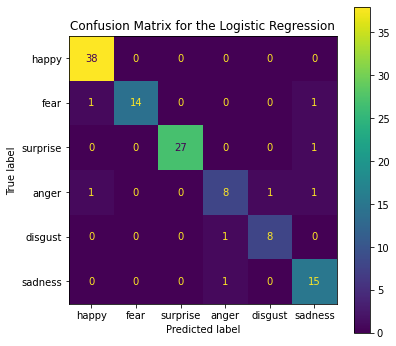

In [304]:
matrix = ConfusionMatrixDisplay(confusion_matrix(test.loc[:, "emotion"], lr.predict(test.loc[:, "0":"135"])), display_labels=emotions)
matrix.plot()
matrix.ax_.set_title("Confusion Matrix for the Logistic Regression")
fig = matrix.ax_.get_figure() 
fig.set_figwidth(6)
fig.set_figheight(6) 

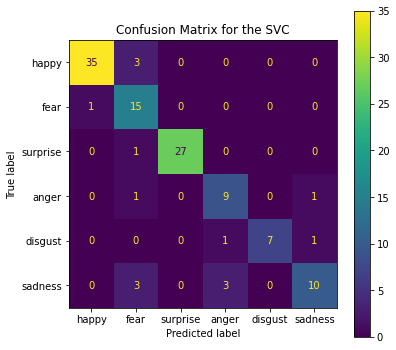

In [306]:
matrix = ConfusionMatrixDisplay(confusion_matrix(test.loc[:, "emotion"], svc.predict(test.loc[:, "0":"135"])), display_labels=emotions)
matrix.plot()
matrix.ax_.set_title("Confusion Matrix for the SVC")
fig = matrix.ax_.get_figure() 
fig.set_figwidth(6)
fig.set_figheight(6) 

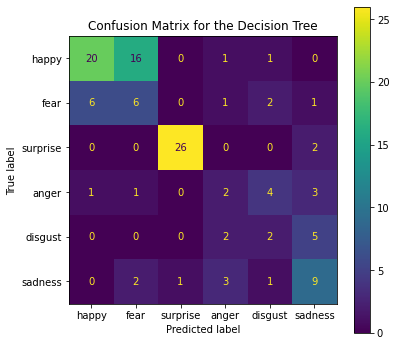

In [307]:
matrix = ConfusionMatrixDisplay(confusion_matrix(test.loc[:, "emotion"], tree.predict(test.loc[:, "0":"135"])), display_labels=emotions)
matrix.plot()
matrix.ax_.set_title("Confusion Matrix for the Decision Tree")
fig = matrix.ax_.get_figure() 
fig.set_figwidth(6)
fig.set_figheight(6) 